# Телеграмм-канал "Кинопоиск"
**Цель исследования:** выявление наиболее эффективных и точных метрик для еженедельного/ежемесячного анализа работы в контексте привлечения подписчиков к канал. Формирование списка KPI для дальнейшей работы и отслеживания заказчиком.

**Задачи проекта:**
  1. Вывести метрики эффективности поста\
    a. Тип публикации\
    b. Тема\
    c. Объем текста\
    d. Отсутствие / наличие эмодзи\
    e. Отсутствие / наличие изображений\
    f. Знаки препинания (сложность текста)

  2. Семантический анализ комментариев к постам, с целью определить, какие посты побуждают людей к действию.
  3. Анализ эмодзи / реакций
  4. Посчитать метрики эффективности каждого поста\
    a. Охват публикаций\
    b. Вовлеченность аудитории
  5. Исследование корреляции характеристик и метрик постов с привлечением новых пользователей в канал Кинопоиска
  6. Формирование краткого отчета по результатам поведенного анализа

In [1]:
#!pip install phik
#!pip install pymorphy2

In [2]:
from google.colab import drive
from IPython.display import Image, display
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import pandas as pd
import numpy as np
import ast
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import string
import re
import phik
from wordcloud import WordCloud
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
import pymorphy2
from pymorphy2 import MorphAnalyzer
import textwrap
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
#drive.mount('/content/drive/')

## Базовый анализ данных

Загрузим функцию, которая будет на вход принимать датафрейм, а на выходе будет выводить все необходимые характеристики, поочередно применяя методы head, describe, info, duplicated и unique:

In [4]:
def checking_data(data):
    """Производит набор операций, необходимых для изучения dataframe: head, describe, info, duplicated, unique

    В качестве аргумента принимает на вход датафрейм
    """
    print('Обзор данных:')
    display(data.head())
    print('Краткий обзор набора данных:\n')
    data.info()
    print()
    print('Количество пропусков в данных:\n', data.isna().sum())
    print()
    print('Количество дубликатов в данных:', data.duplicated().sum())
    print()
    print('Уникальные значения по возрастанию в начале и конце столбцов:')
    for column in data:#создадим цикл для автоматизированного ввода названий колонок
        try: # обезопасим код
            print(column,':\n', sorted(data[column].unique())[:10], 'Конец списка:',sorted(data[column].unique())[-10:], '\n',
'Количество уникальных значений в',column, '-', data[column].nunique(dropna = True), '\n')
        except:
            print(column,'Сортировка невозможна!', 'Количество уникальных значений в',column, '-', data[column].nunique(), '\n')
            if len(data[column].unique()) < 50:
                print(column,':\n', data[column].unique(), '\n')

    print()
    print('Cписок характерных значений данных:')
    display(round(data.describe(), 1))

Проанализируем имеющиеся данные:

In [5]:
#загружаем датасет о подписчиках канала и их количестве в разбивке по дням
df_subs_days = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kinopoisk_subscribers_general_2024_18_01.csv', index_col=0, parse_dates=['date'], dayfirst=True)


In [6]:
checking_data(df_subs_days)

Обзор данных:


date  subscribers  changes
0 2024-01-18       551378      415
1 2024-01-17       550963     2061
2 2024-01-16       548902     2043
3 2024-01-15       546859     2539
4 2024-01-14       544320     2021

Краткий обзор набора данных:

<class 'pandas.core.frame.DataFrame'>
Index: 520 entries, 0 to 519
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         520 non-null    datetime64[ns]
 1   subscribers  520 non-null    int64         
 2   changes      520 non-null    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 16.2 KB

Количество пропусков в данных:
 date           0
subscribers    0
changes        0
dtype: int64

Количество дубликатов в данных: 0

Уникальные значения по возрастанию в начале и конце столбцов:
date :
 [Timestamp('2022-08-17 00:00:00'), Timestamp('2022-08-18 00:00:00'), Timestamp('2022-08-19 00:00:00'), Timestamp('2022-08-20 00:00:00'), Timestamp('2022-08-21 00:00:00'), Timestamp('2022-08-22 00:00:00'), Timestamp('2022-08-23 00:00:00'), Timestamp('2022-08-24 00:00:00'), Timestamp('2022-08-25 00:00:00'), Timestamp('2022-08-26 00:00:00')] Конец списка: [Timestamp

date  subscribers  changes
count                  520        520.0    520.0
mean   2023-05-03 12:00:00     276901.2    664.7
min    2022-08-17 00:00:00     205805.0  -1254.0
25%    2022-12-24 18:00:00     224990.8      7.2
50%    2023-05-03 12:00:00     261064.0    153.5
75%    2023-09-10 06:00:00     289199.2    431.8
max    2024-01-18 00:00:00     551378.0   9844.0
std                    NaN      75426.7   1495.4

Описание данных:
- date - дата
- subscribers - суммарное количество подписок на эту дату
- changes - разница в количестве подписчиков между текущей и предыдущей датой

Данный датафрейм выглядит беспроблемным. Явные дубликаты и пропуски отсутствуют. Наличие выбросов по краям диапазонов не фиксируется. Формат данных соответсвуют их содержанию.

*Итак, мы имеем данныe за период с 9 января 2022 года по 18 января 2024. За это время количество подписчиков выросло с 205805 до 551378. Максимальный единовременный прирост за период составил 9844 подписчика. Максимальное доминирование отписки над подпиской - 1254. Средний рост составил 665 единиц, медианный - 154, что свидетельствует о том, что прирост подписчиков в рассматриваемый период зачастую носил неравномерный, "взрывной" характер.\
Установим даты, в которые был максимальный прирост и максимальный отток подписчиков:*

In [7]:
df_subs_days.query('changes == -1254')

date  subscribers  changes
36 2023-12-13       440327    -1254

In [8]:
df_subs_days.query('changes == 9844')

date  subscribers  changes
312 2023-03-12       251101     9844

*Максимальное единовременое уменьшение подписчиков следует за максимальным увеличением с промежутком в 10 дней, что может свидетельствовать о взаимосвязи между ними. Рассмотрим вопрос о соотношении отписок-подписок в датасете с детальной информацией о подписчиках канала и отписках:*

In [9]:
# загружаем датасет количества подписок/отписок с разбивкой по часам

df_subs_unsubs_hous = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kinopisk_subscribers_detailed_2024-01-18.csv', index_col=0)

In [10]:
checking_data(df_subs_unsubs_hous)

Обзор данных:


date   time  subscribers  unsubscribed
0  Чт, 18 Jan  11:29          204          -300
1  Чт, 18 Jan  11:00          373          -366
2  Чт, 18 Jan  10:00          333          -150
3  Чт, 18 Jan  09:00          211          -133
4  Чт, 18 Jan  08:00          152           -90

Краткий обзор набора данных:

<class 'pandas.core.frame.DataFrame'>
Index: 12282 entries, 0 to 12281
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          12282 non-null  object
 1   time          12282 non-null  object
 2   subscribers   12282 non-null  int64 
 3   unsubscribed  12282 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 479.8+ KB

Количество пропусков в данных:
 date            0
time            0
subscribers     0
unsubscribed    0
dtype: int64

Количество дубликатов в данных: 0

Уникальные значения по возрастанию в начале и конце столбцов:
date :
 ['Вс, 1 Jan 2023', 'Вс, 1 Oct 2023', 'Вс, 10 Dec 2023', 'Вс, 10 Sep 2023', 'Вс, 11 Dec 2022', 'Вс, 11 Jun 2023', 'Вс, 11 Sep 2022', 'Вс, 12 Feb 2023', 'Вс, 12 Mar 2023', 'Вс, 12 Nov 2023'] Конец списка: ['Чт, 6 Jul 2023', 'Чт, 6 Oct 2022', 'Чт, 7 Dec 2023', 'Чт, 7 Sep 2023', 'Чт, 8 Dec 2022', 'Чт, 8 Jun 2023', 'Чт, 8 Sep 2022', 'Чт, 9 Fe

subscribers  unsubscribed
count      12282.0       12282.0
mean          78.4         -49.9
std          153.4          88.6
min            0.0        -732.0
25%            0.0         -64.0
50%           21.0         -13.0
75%           77.0           0.0
max         1553.0           0.0

Первое, что бросается в глаза - в столбце `data` не указан год во всех датах 2024 года. В последующем это может помешать корректной обработке данных.
Кроме того, формат данных не соответсвует их содержанию. Дата задана в формате `object`, что делает невозможным правильную сортировку и также может создавать трудности. Датасет подлежит коректировке:

In [11]:
#создадим лямбда-функцию для корректировки данных
df_subs_unsubs_hous['date'] = df_subs_unsubs_hous['date'].apply(lambda x: x + ' 2024' if len(x.split()) == 3 else x)

In [12]:
#проверяем результат
df_subs_unsubs_hous.head(5)

date   time  subscribers  unsubscribed
0  Чт, 18 Jan 2024  11:29          204          -300
1  Чт, 18 Jan 2024  11:00          373          -366
2  Чт, 18 Jan 2024  10:00          333          -150
3  Чт, 18 Jan 2024  09:00          211          -133
4  Чт, 18 Jan 2024  08:00          152           -90

Судя по всему, функция отработала корректно. Теперь преобразуем столбец `date` в формат `datatime`:

In [13]:
#переносим день недели в отдельный столбец
df_subs_unsubs_hous['day'] = df_subs_unsubs_hous['date'].apply(lambda x: x.split(',')[0])

#удаляем день недели из столбца date
df_subs_unsubs_hous['date'] = df_subs_unsubs_hous['date'].apply(lambda x: x.split(',')[1])

#преобразуем данные date в формат datetime
df_subs_unsubs_hous['date'] = pd.to_datetime(df_subs_unsubs_hous['date'])

#проверяем результат
df_subs_unsubs_hous.head(5)

date   time  subscribers  unsubscribed day
0 2024-01-18  11:29          204          -300  Чт
1 2024-01-18  11:00          373          -366  Чт
2 2024-01-18  10:00          333          -150  Чт
3 2024-01-18  09:00          211          -133  Чт
4 2024-01-18  08:00          152           -90  Чт

Код отработал корректно. Проверяем датасет повторно:

In [14]:
#анализируем датасет
checking_data(df_subs_unsubs_hous)

Обзор данных:


date   time  subscribers  unsubscribed day
0 2024-01-18  11:29          204          -300  Чт
1 2024-01-18  11:00          373          -366  Чт
2 2024-01-18  10:00          333          -150  Чт
3 2024-01-18  09:00          211          -133  Чт
4 2024-01-18  08:00          152           -90  Чт

Краткий обзор набора данных:

<class 'pandas.core.frame.DataFrame'>
Index: 12282 entries, 0 to 12281
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          12282 non-null  datetime64[ns]
 1   time          12282 non-null  object        
 2   subscribers   12282 non-null  int64         
 3   unsubscribed  12282 non-null  int64         
 4   day           12282 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 833.8+ KB

Количество пропусков в данных:
 date            0
time            0
subscribers     0
unsubscribed    0
day             0
dtype: int64

Количество дубликатов в данных: 0

Уникальные значения по возрастанию в начале и конце столбцов:
date :
 [Timestamp('2022-08-17 00:00:00'), Timestamp('2022-08-18 00:00:00'), Timestamp('2022-08-19 00:00:00'), Timestamp('2022-08-20 00:00:00'), Timestamp('2022-08-21 00:00:00'), Timestamp('2022-08-22 00:00:00'),

date  subscribers  unsubscribed
count                          12282      12282.0       12282.0
mean   2023-05-02 00:30:50.122129920         78.4         -49.9
min              2022-08-17 00:00:00          0.0        -732.0
25%              2022-12-23 00:00:00          0.0         -64.0
50%              2023-05-01 00:00:00         21.0         -13.0
75%              2023-09-08 00:00:00         77.0           0.0
max              2024-01-18 00:00:00       1553.0           0.0
std                              NaN        153.4          88.6

Описание данных:
   - date - дата
   - time - время
   - subscribers - количество подписавшихся
   - unsubscribed - количество отписок
   - day - день недели

Корректировка данных проведена успешно. Явные дубликаты и пропуски отсутствуют. Наличие выбросов по краям диапазонов не фиксируется. Формат данных соответсвуют их содержанию.

Данныe в датасете приведены за период с 17 августа 2022 года по 18 января 2024. Максимальная подписка в час за весь период была зафиксирована на уровне 1553. Максимальная отписка - 732. Средний рост составил 79 единиц, отписка - 49. Медианная подписка - 21, отписка - 13. Что свидетельствует о том, что протекали эти процессы в рассматриваемый период очень неравномерно.
Установим дату и время, в которые была максимальная подписка и отписка:
  

In [15]:
df_subs_unsubs_hous.query('subscribers == 1553')

date   time  subscribers  unsubscribed day
7338 2023-03-12  21:00         1553             0  Вс

In [16]:
df_subs_unsubs_hous.query('unsubscribed == -732')

date   time  subscribers  unsubscribed day
410 2024-01-01  01:00          495          -732  Пн

Даты рекордов в первом приближении выглядят несвязанными между собой. Необходимо будет рассмотреть общую картину на следующих этапах.

In [17]:
# загружаем датасет со сведениями о постах в телеграм канале Кинопоиска
df_posts = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kinopoisk_channel_posts_2023-01-21.csv',
                       index_col=0, parse_dates=['date'], dayfirst=True, usecols=lambda column: column not in ['channel', 'with_media', 'replies'])

In [18]:
df_posts.head()

id                      date  \
0  37125 2024-01-21 08:02:21+00:00   
4  37121 2024-01-20 18:01:00+00:00   
5  37120 2024-01-20 16:01:16+00:00   
6  37119 2024-01-20 14:20:04+00:00   
7  37118 2024-01-20 10:48:48+00:00   

                                                text    views  \
0  Какими подростками были актеры из «Трудных под...  12744.0   
4  Фильм дня — [**«Дневник Бриджит Джонс»**](http...  49486.0   
5  Кристоферу Нолану [вручат](https://www.hollywo...  53713.0   
6  Отгадайте фильм: в жизни грустной девочки появ...  55890.0   
7  Правда или фейк? 🧐\n\n#ДежурныйПоКинопоиску Се...  60348.0   

                                           reactions  forwarded  \
0  {'_': 'MessageReactions', 'results': [{'_': 'R...       12.0   
4  {'_': 'MessageReactions', 'results': [{'_': 'R...      161.0   
5  {'_': 'MessageReactions', 'results': [{'_': 'R...      136.0   
6  {'_': 'MessageReactions', 'results': [{'_': 'R...      148.0   
7  {'_': 'MessageReactions', 'results': [{'_': 'R...       27.0   

   reactions_count  comments       type_attachment  
0               57         5   MessageMediaWebPage  
4              896        85     MessageMediaPhoto  
5             1782        68     MessageMediaPhoto  
6              189        12   MessageMediaWebPage  
7              210         3  MessageMediaDocument

In [19]:
#откорректируем время на MSK (+3 часа)
df_posts['date'] += pd.to_timedelta('3 hours')
df_posts['date'] = df_posts['date'].dt.tz_localize(None)

#заменяем type_attachment на понятную лексику
df_posts['type_attachment'].replace({'MessageMediaPhoto': 'фото', 'MessageMediaDocument': 'видео', 'MessageMediaWebPage': 'ссылка'}, inplace=True)

#удаляем всю информацию, ранее 1 января 2023 года
df_posts.drop(df_posts[df_posts['date'] < '2022-08-17'].index, inplace=True)

#сбрасываем индекс
df_posts = df_posts.reset_index(drop=True)

In [20]:
#создаём функцию для извлечения информации об эмодзи из колонки 'reactions'
"""Создаёт словарь с перечислением эмотиконов и их количеством

    В качестве аргумента принимает на вход столбец 'reactions'
"""
def update_emoji_counts(data_string):
    # Преобразование строки в словарь с помощью ast.literal_eval
    if pd.isnull(data_string):  # Проверка на NaN
       return 0
    data = ast.literal_eval(data_string)

    emoji_counts = {}
    for result in data['results']:
        emoji = result['reaction']['emoticon']
        count = result['count']
        if emoji in emoji_counts:
            emoji_counts[emoji] += count
        else:
            emoji_counts[emoji] = count
    return emoji_counts

In [21]:
#применяем функцию для подсчёта эмодзи
df_posts['emoji'] = df_posts['reactions'].apply(update_emoji_counts)

In [22]:
#получаем датасет с эмотиконами
df_emoji = pd.json_normalize(df_posts['emoji'])

#заполняем пропуски нулями для удобства восприятия
df_emoji.fillna(0, inplace=True)

#объединяем два датасета:
df_posts = df_posts.join(df_emoji)

#удаляем из результирующего датасета "технические" столбцы, уже использованные для вычислений
df_posts.drop(['reactions', 'emoji'], axis=1, inplace=True)

In [23]:
#анализируем датасет
checking_data(df_posts)

Обзор данных:


id                date  \
0  37125 2024-01-21 11:02:21   
1  37121 2024-01-20 21:01:00   
2  37120 2024-01-20 19:01:16   
3  37119 2024-01-20 17:20:04   
4  37118 2024-01-20 13:48:48   

                                                text    views  forwarded  \
0  Какими подростками были актеры из «Трудных под...  12744.0       12.0   
1  Фильм дня — [**«Дневник Бриджит Джонс»**](http...  49486.0      161.0   
2  Кристоферу Нолану [вручат](https://www.hollywo...  53713.0      136.0   
3  Отгадайте фильм: в жизни грустной девочки появ...  55890.0      148.0   
4  Правда или фейк? 🧐\n\n#ДежурныйПоКинопоиску Се...  60348.0       27.0   

   reactions_count  comments type_attachment       ❤      👍  ...    🥱    😐  \
0               57         5          ссылка    41.0    8.0  ...  0.0  0.0   
1              896        85            фото   657.0  110.0  ...  0.0  0.0   
2             1782        68            фото  1585.0   40.0  ...  0.0  0.0   
3              189        12          ссылка   124.0   31.0  ...  0.0  0.0   
4              210         3           видео   122.0   50.0  ...  0.0  0.0   

     🎅    👌    💩    🤮    🖕    🤡    🤨    🥴  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 68 columns]

Краткий обзор набора данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4594 entries, 0 to 4593
Data columns (total 68 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               4594 non-null   int64         
 1   date             4594 non-null   datetime64[ns]
 2   text             4594 non-null   object        
 3   views            4594 non-null   float64       
 4   forwarded        4594 non-null   float64       
 5   reactions_count  4594 non-null   int64         
 6   comments         4594 non-null   int64         
 7   type_attachment  4568 non-null   object        
 8   ❤                4594 non-null   float64       
 9   👍                4594 non-null   float64       
 10  🐳                4594 non-null   float64       
 11  👎                4594 non-null   float64       
 12  ❤‍🔥              4594 non-null   float64       
 13  💅                4594 non-null   float64       
 14  🔥         

id                           date     views  forwarded  \
count   4594.0                           4594    4594.0     4594.0   
mean   32040.2  2023-03-22 07:56:25.467566592   52804.2      182.2   
min    27590.0            2022-08-17 11:15:24   12744.0        0.0   
25%    29705.2     2022-11-01 15:09:15.500000   39080.5       65.0   
50%    31821.5     2023-02-16 15:01:26.500000   50136.5      126.0   
75%    34290.8            2023-08-08 19:23:34   62038.0      225.8   
max    37125.0            2024-01-21 11:02:21  278962.0     3212.0   
std     2709.2                            NaN   17991.6      203.1   

       reactions_count  comments       ❤       👍       🐳       👎  ...       🥱  \
count           4594.0    4594.0  4594.0  4594.0  4594.0  4594.0  ...  4594.0   
mean             444.3      33.2   133.7   123.1     3.1    39.0  ...     2.0   
min                0.0       0.0     0.0     0.0     0.0     0.0  ...     0.0   
25%              210.0      10.0    15.0    45.0     0.0     4.0  ...     0.0   
50%              314.0      20.0    38.0    77.0     0.0    11.0  ...     0.0   
75%              513.0      38.0   150.8   150.0     4.0    25.0  ...     0.0   
max             8012.0    1010.0  7484.0  3418.0   386.0  4757.0  ...   333.0   
std              478.1      56.3   289.0   159.4    13.5   153.5  ...    10.8   

            😐       🎅       👌       💩       🤮       🖕       🤡       🤨       🥴  
count  4594.0  4594.0  4594.0  4594.0  4594.0  4594.0  4594.0  4594.0  4594.0  
mean      1.7     0.0     0.3     1.5     1.4     0.1     0.6     0.2     0.1  
min       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
25%       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
50%       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
75%       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
max     359.0     9.0   193.0   558.0   394.0    33.0   438.0   118.0   102.0  
std      11.3     0.2     4.2    13.3    11.6     0.7     9.8     2.7     1.8  

[8 rows x 66 columns]

Описание данных:
  - id - идентификатор поста
  - date - дата и время публикации поста MSK
  - text - текст поста
  - views - количество просмотров поста
  - forwarded - сколько раз пересылался пост
  - reactions_count - количество реакций/эмоджи
  - comments - количество комментариев к посту
  - type attachement - вид прикрепленного к посту документа

Корректировка данных проведена успешно. Явные дубликаты отсутсвуют. Количество пропусков незначительно по отношению к общему объёму данных. Наличие выбросов по краям диапазонов не фиксируется. Формат данных соответсвуют их содержанию.

Данныe в датасете приведены за период с 17 августа 2022 года по 21 января 2024, с id постов от 27590 до 37125. Минимальное количество просмотров одного поста - 12744, максимальное - 278962. Минимальное количество пересылок - 0, максимальное 3212. Минимальное количество реакций на пост - 0, максимальное - 8012. Количество комментариев колеблется в диапазоне от 0 до 1010.

In [24]:
#загружаем датасет с комментариями пользователей
df_comments = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/comments_kinopisk_2023_01_18.csv',
                          index_col=0, parse_dates=['date_comment'], dayfirst=True, usecols=lambda column: column not in ['Unnamed: 0'])
#переименовываем колонки
df_comments = df_comments.rename(columns={'post_id': 'id', 'date_comment': 'date'})

#откорректируем время на MSK (+3 часа)
df_comments['date'] += pd.to_timedelta('3 hours')
df_comments['date'] = df_comments['date'].dt.tz_localize(None)

#удаляем явные дубликаты
df_comments = df_comments.drop_duplicates().reset_index(drop=True)

In [25]:
#анализируем датасет
checking_data(df_comments)

Обзор данных:


id                date  \
0  37068 2024-01-18 12:34:31   
1  37068 2024-01-18 12:35:00   
2  37068 2024-01-18 12:35:11   
3  37068 2024-01-18 12:36:34   
4  37068 2024-01-18 12:37:41   

                                        text_comment  
0  От бесстыжих к медведю - так это скорее не пут...  
1                                 учился орать FUCK!  
2                                   Верните бестыжих  
3      От липа из бесстыжих до рекламы кельвин кляйн  
4           этот навык был освоен еще в "бесстыжих"🧡

Краткий обзор набора данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138902 entries, 0 to 138901
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            138902 non-null  int64         
 1   date          138902 non-null  datetime64[ns]
 2   text_comment  132175 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 3.2+ MB

Количество пропусков в данных:
 id                 0
date               0
text_comment    6727
dtype: int64

Количество дубликатов в данных: 0

Уникальные значения по возрастанию в начале и конце столбцов:
id :
 [28701, 28711, 28712, 28713, 28714, 28715, 28716, 28717, 28720, 28723] Конец списка: [37051, 37052, 37053, 37057, 37058, 37059, 37060, 37064, 37066, 37068] 
 Количество уникальных значений в id - 3931 

date :
 [Timestamp('2022-09-22 16:31:20'), Timestamp('2022-09-22 16:31:55'), Timestamp('2022-09-22 16:33:04'), Timestamp

id                           date
count  138902.0                         138902
mean    33116.7  2023-05-20 22:54:35.886286848
min     28701.0            2022-09-22 16:31:20
25%     31471.0  2023-01-30 06:59:27.750000128
50%     32971.0            2023-05-10 17:39:27
75%     34911.0  2023-09-18 14:05:08.750000128
max     37068.0            2024-01-19 10:12:55
std      2217.6                            NaN

Описание данных:
  - id - идентификатор поста к которому написан комментарий
  - date - дата и время публикации комментария MSK
  - text_comment - текст поста

Корректировка данных проведена успешно. Явные дубликаты отсутсвуют. Пропуски, в колонке text_comment вероятно, обусловлены отсутствием комментариев к определённым постам. Наличие выбросов по краям диапазонов не фиксируется. Формат данных соответсвуют их содержанию.

Данныe в датасете приведены за период с 22 сентября 2022 года по 19 января 2024, с комментариями к постам с id от 28701 до 37068.

Пока непонятно, понадобятся ли эти данные в рамках исследования, но в случае необходимости они готовы к работе.

In [26]:
# загружаем данные за 3 месяца о телеграмканалах и группах, в которых есть репосты либо упоминания Кинопоиска в своих постах
df_rep_ment = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kinopisk_reposts_and_mentions_2023_19_01.csv', index_col=0)

In [27]:
#просматриваем результат
df_rep_ment.head(5)

channel  number_subscribers  \
0  Обсуждаем фильмы. Поиском кино не занимаемся                1358   
1                                     🎬 КиноДед                1409   
2                                        супер8               22276   
3                                       Стримми               13152   
4  Обсуждаем фильмы. Поиском кино не занимаемся                1359   

             action           date  
0  репостнул запись  19 Jan, 10:02  
1  репостнул запись  18 Jan, 23:33  
2    упомянул канал  18 Jan, 22:48  
3    упомянул канал  18 Jan, 22:35  
4    упомянул канал  18 Jan, 21:02

Очевидно, что даты за 2024 год приведены без указания года. Откорректируем данные:

In [28]:
#создадим лямбда-функцию для корректировки данных
df_rep_ment['date'] = df_rep_ment['date'].apply(lambda x: x.replace(',', ' 2024, ') if len(x.split()) == 3 else x)

#преобразуем данные date в формат datetime
df_rep_ment['date'] = pd.to_datetime(df_rep_ment['date'])

#удаляем явные дубликаты
df_rep_ment.drop_duplicates(inplace=True)

In [29]:
#анализируем датасет
checking_data(df_rep_ment)

Обзор данных:


channel  number_subscribers  \
0  Обсуждаем фильмы. Поиском кино не занимаемся                1358   
1                                     🎬 КиноДед                1409   
2                                        супер8               22276   
3                                       Стримми               13152   
4  Обсуждаем фильмы. Поиском кино не занимаемся                1359   

             action                date  
0  репостнул запись 2024-01-19 10:02:00  
1  репостнул запись 2024-01-18 23:33:00  
2    упомянул канал 2024-01-18 22:48:00  
3    упомянул канал 2024-01-18 22:35:00  
4    упомянул канал 2024-01-18 21:02:00

Краткий обзор набора данных:

<class 'pandas.core.frame.DataFrame'>
Index: 2221 entries, 0 to 2305
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   channel             2221 non-null   object        
 1   number_subscribers  2221 non-null   int64         
 2   action              2221 non-null   object        
 3   date                2221 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 86.8+ KB

Количество пропусков в данных:
 channel               0
number_subscribers    0
action                0
date                  0
dtype: int64

Количество дубликатов в данных: 0

Уникальные значения по возрастанию в начале и конце столбцов:
channel :
 ['#КатяПовараЖена', '(ЛесяЛя)', '051', '500 дней Даулета', '8 БИТ. Яндекс для школьников', '99 problems льва алекса', 'Aktualności', 'Alperina', 'Anntresol. Анна Абалмазова', 'Another Day of Sundance'] Конец спис

number_subscribers                           date
count              2221.0                           2221
mean               3270.7  2023-12-03 18:55:35.848716800
min                  50.0            2023-10-22 13:08:00
25%                  52.0            2023-11-11 14:02:00
50%                1362.0            2023-11-30 13:01:00
75%                1376.0            2023-12-27 12:22:00
max              219882.0            2024-01-19 10:02:00
std               12848.5                            NaN

Описание данных:
  - channel - канал или группа, который сделал репост/упоминание Кинопоиска
  - number_subscribers - количество подписчиков у этого канала
  - action - тип действия - репост или упоминание
  - date - когда было произведено действие

Корректировка данных проведена успешно. Явные дубликаты и пропуски отсутсвуют.  Наличие выбросов по краям диапазонов не фиксируется. Формат данных соответсвуют их содержанию.

Данныe в датасете приведены за период с 22 октября 2023 года по 19 января 2024.
Количество различных каналов, в которых был упомянут Кинопоиск - 395, с количеством подписчиков от 50 до 219882.

Данные можно попытаться использовать для учёта внешнего влияния на прирост подписчиков канала Кинопоиск.

Оценим распространённость действий на сторонних каналах:

In [30]:
df_rep_ment.pivot_table(index=['action'], values='channel', aggfunc='count').rename(columns={'channel': 'qvt_actions'})

qvt_actions
action                       
репостнул запись          900
упомянул запись           228
упомянул канал           1093

Как мы видим, самым распространённым действием является упоминание канала и перепост его записей. Простое упоминание постов встречается минимум в 3 раза реже.

На этом базовый анализ и подготовку данных будем считать завершёнными. Переходим на следующий этап.

## Исследовательский анализ данных

### Анализ динамики изменения количества подписчиков
Для выявления возможных закономерностей в изменении количества подписчиков со временем, визуализируем этот процесс в виде наскольких графиков:

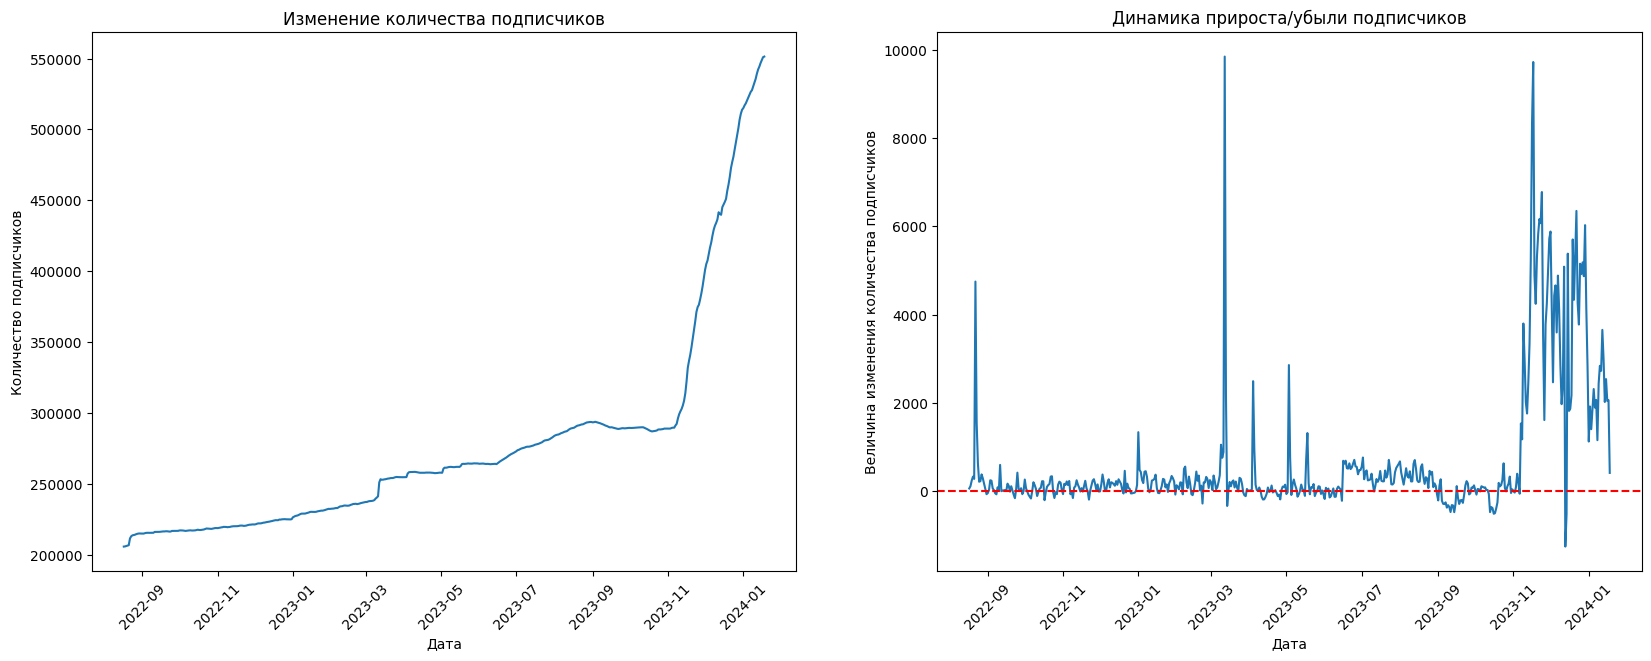

In [31]:
# Создаем графики в одной строке
fig, axs = plt.subplots(1, 2, figsize=(20, 7))

# Первый график
axs[0].plot(df_subs_days['date'], df_subs_days['subscribers'])
axs[0].set_title('Изменение количества подписчиков')
axs[0].set_xlabel('Дата')
axs[0].set_ylabel('Количество подписчиков')
axs[0].tick_params(axis='x', rotation=45)

# Второй график
axs[1].plot(df_subs_days['date'], df_subs_days['changes'])
axs[1].axhline(0, color='r', linestyle='--')
axs[1].set_title('Динамика прироста/убыли подписчиков')
axs[1].set_xlabel('Дата')
axs[1].set_ylabel('Величина изменения количества подписчиков')
axs[1].tick_params(axis='x', rotation=45)

# Показываем графики
plt.show()

С помощью визуализаций мы можем выделить периоды роста, стагнации и отката числа подписчиков Кинопоиска:
- период небольшого, но устойчивого роста с тенденцией к ускорению наблюдался с августа 2022 года по начало марта 2023 года;
- период стагнации возник сразу после резкого всплеска подписки в начале марта 2023 года и продолжался до середины июня;
- период устойчивого роста далее длится до сентября 2023 года;
- период отката ясно виден с сентября по середину ноября 2023 года;
- период крутого роста отмечается с середины ноября по начало января 2024 года.

График динамики прироста/убыли подписчиков полностью согласуется с предыдущим. При этом на нём мы можем видеть ряд аномальных пиковых значений, очевидно нуждающихся в дальнейшем качественном и количественном анализе. Выделим эти даты, взяв за уровень отсечки приток в 6000 подписчиков:

In [32]:
df_subs_days.query('changes > 6000')[['date', 'changes']].sort_values(by='date').reset_index(drop=True)

date  changes
0 2023-03-12     9844
1 2023-11-16     8303
2 2023-11-17     9721
3 2023-11-22     6163
4 2023-11-23     6070
5 2023-11-24     6776
6 2023-12-22     6348
7 2023-12-29     6026

Очевидно, что отдельного внимания заслуживает самый первый пик, случившийся в августе 2022 года. Узнаем его дату также:

In [33]:
df_subs_days[-10:].query('changes > 4000')[['date', 'changes']].sort_values(by='date').reset_index(drop=True)

date  changes
0 2022-08-22     4748

Даты резкого падения уровня подписчиков также не менее интересны:

In [34]:
df_subs_days.query('changes < -480')[['date', 'changes']].sort_values(by='date').reset_index(drop=True)

date  changes
0 2023-10-16     -511
1 2023-10-17     -498
2 2023-12-13    -1254
3 2023-12-14     -521

### Анализ динамики подписки/отписки
Теперь попробуем выявить закономерности детализированных данных динамики подписки/отписки.

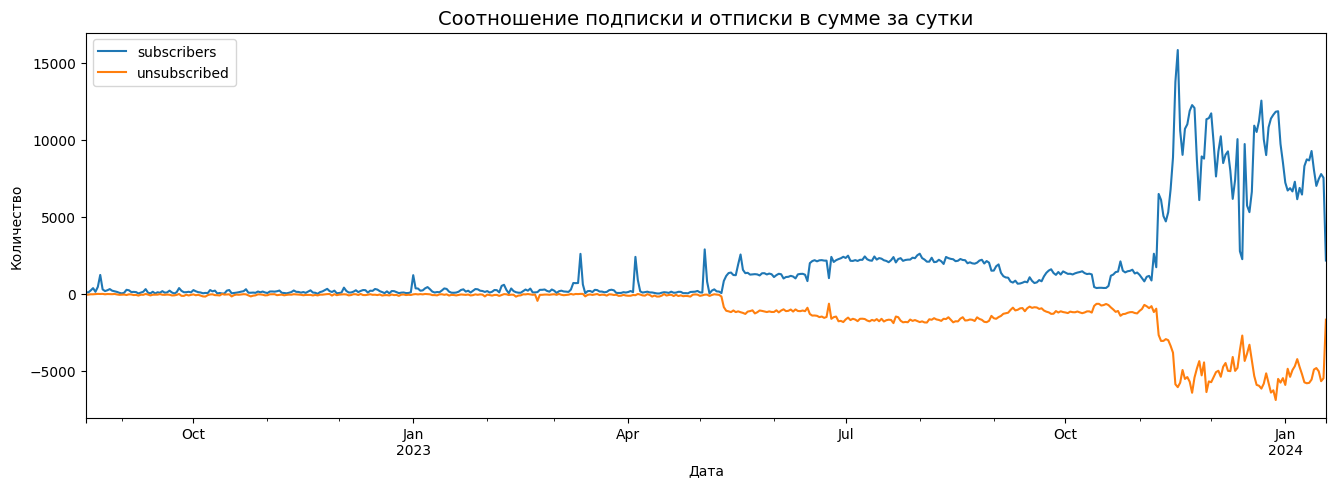

In [35]:
#рисуем соотношение подписки и отписки в сумме за сутки
df_subs_unsubs_hous.pivot_table(index='date', values = ['subscribers', 'unsubscribed'], aggfunc='sum').plot(figsize=(16, 5), ylabel='Количество',
xlabel='Дата')
plt.title('Соотношение подписки и отписки в сумме за сутки', fontsize=14)
plt.show()


Интересным является тот факт, что линии подписки и отписки зачастую симметричны и в момент, когда падает подписка, отписка тоже уменьшается. Это можно объяснить только тем, что большинство подписчиков не задерживаются на канале долго и отписываются очень быстро. Взглянем на тот же процесс в относительных цифрах. Установим, какая доля из подписавшихся остаётся или покидает канал, для чего визуализируем отношение разности подписки и отписки к поличеству подписавшихся.

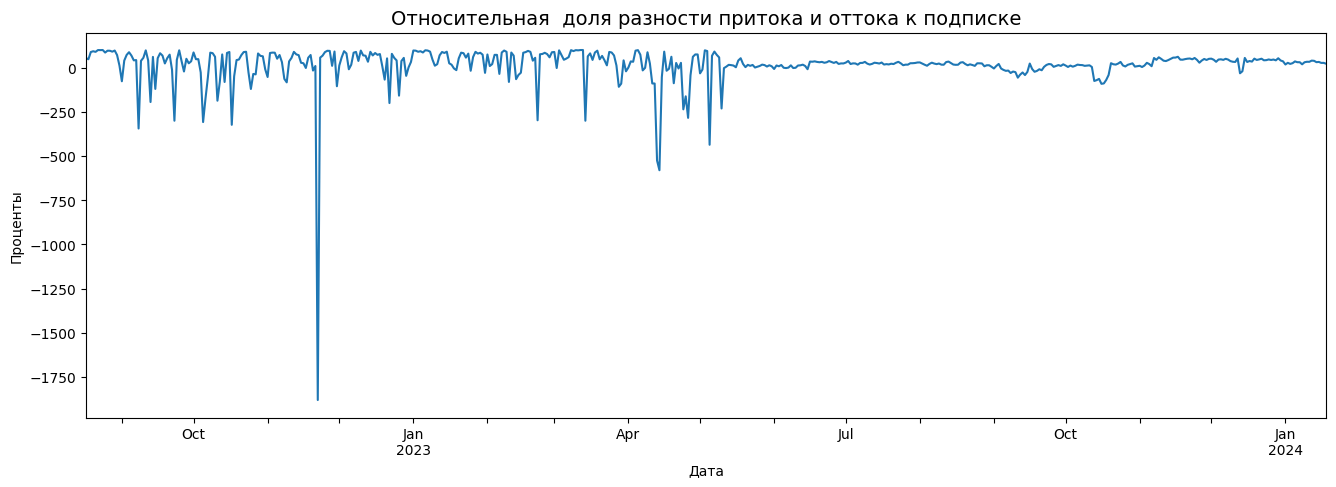

In [36]:
df_ratio = df_subs_unsubs_hous.pivot_table(index='date', values = ['subscribers', 'unsubscribed'], aggfunc='sum')
df_ratio['ratio'] = (df_ratio['subscribers']+df_ratio['unsubscribed'])/df_ratio['subscribers']*100
df_ratio['ratio'].plot(figsize=(16, 5), xticks=pd.date_range(df_ratio.index.min(), df_ratio.index.max(), freq='MS'), ylabel='Проценты', xlabel='Дата');
plt.title('Относительная  доля разности притока и оттока к подписке', fontsize=14)
plt.show()

Ми видим, что до  июня 2023 года относительные колебания были очень большие в силу малых абсолютных значений подписавшихся и отписавшихся. С июня 2023 года ситуация резко меняется, поэтому посмотрим на этот период более подробно:

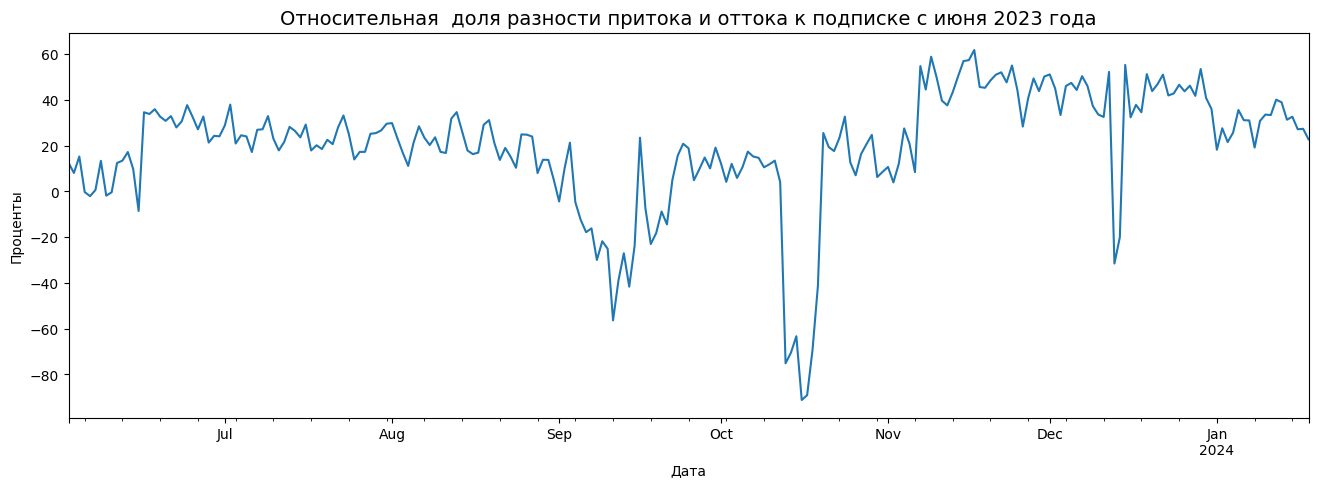

In [37]:
df_ratio.query('index > "2023-06-01"')['ratio'].plot(figsize=(16, 5), ylabel='Проценты', xlabel='Дата');
plt.title('Относительная  доля разности притока и оттока к подписке с июня 2023 года', fontsize=14)
plt.show()

В целом, мы опять можем констатировать значительное превалирование суточных значений отписки над подпиской в сентябре и середине ноября 2023 года.

Теперь оценим процессы отписки и отписки по времени суток и дням недели. Начнём с времени суток. Проверим временную метку 11:29, насколько она валидна:

In [38]:
#проверяем количество статистики на временной метке 11:29
df_subs_unsubs_hous.query('time == "11:29"')

date   time  subscribers  unsubscribed day
0 2024-01-18  11:29          204          -300  Чт

Как видно, мы имеем на это время одно-единственное наблюдение, а значит статистика по ней не валидна. Исключим её из статистики.

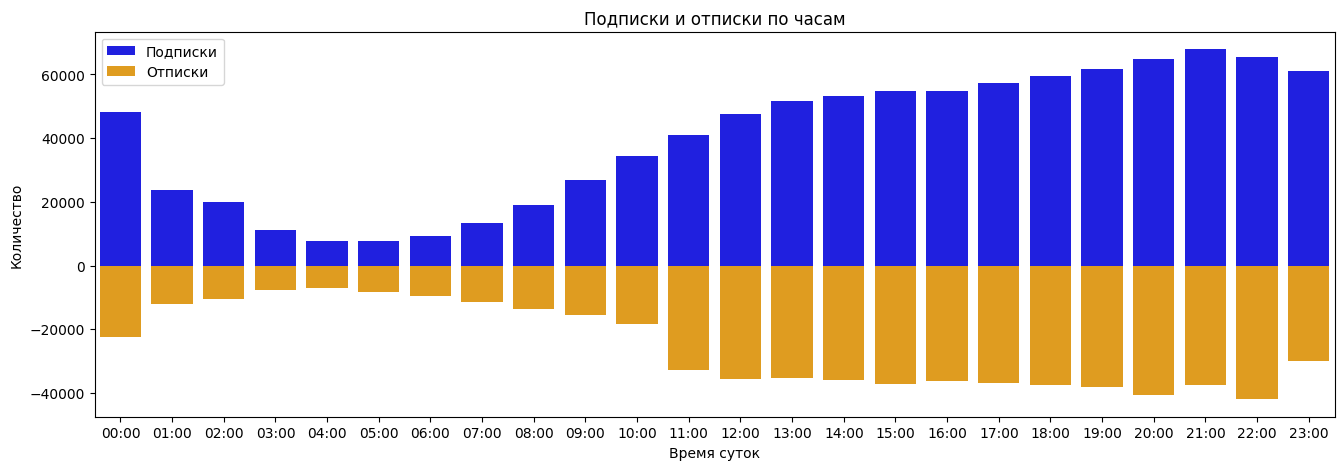

In [39]:
# Создание сводной таблицы
df_pivot = df_subs_unsubs_hous.pivot_table(index='time', values=['subscribers', 'unsubscribed'], aggfunc='sum').query('time != "11:29"').reset_index()

# Построение столбчатой диаграммы
plt.figure(figsize=(16, 5))
sns.barplot(data=df_pivot, x='time', y='subscribers', color='blue', label='Подписки')
sns.barplot(data=df_pivot, x='time', y='unsubscribed', color='orange', label='Отписки')
plt.xlabel('Время суток')
plt.ylabel('Количество')
plt.title('Подписки и отписки по часам')
plt.legend()
plt.show()
plt.show()

Визуально кажется, что ни в один из временных отрезков процесс отписки не превалирует над подпиской, однако, оценим соотношение более точно:

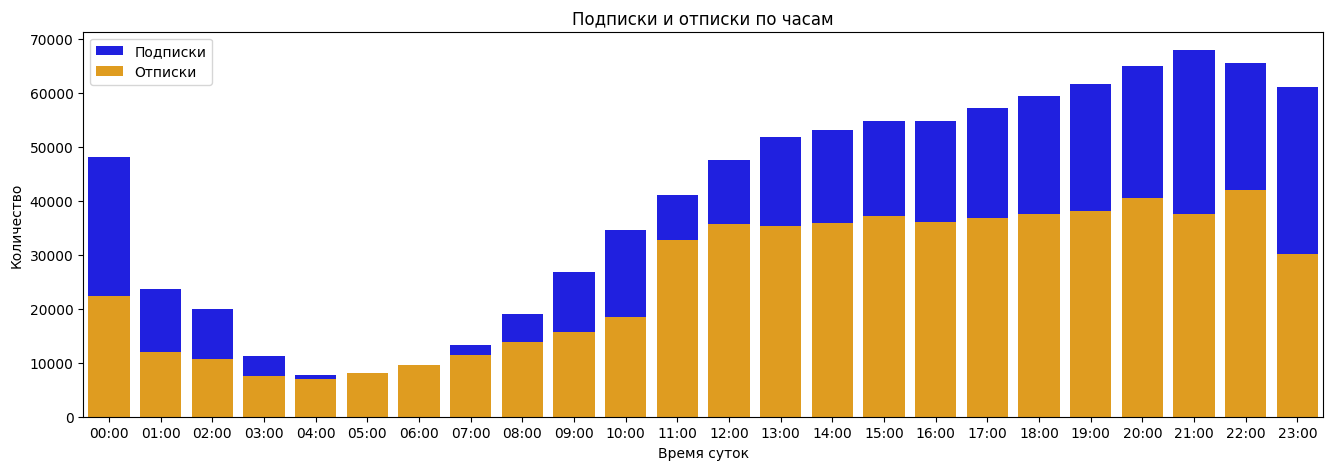

In [40]:
# меняем знак на противоположный unsubscribed
df_pivot['unsubscribed'] = df_pivot['unsubscribed'] * -1

# Построение столбчатой диаграммы
plt.figure(figsize=(16, 5))
sns.barplot(data=df_pivot, x='time', y='subscribers', color='blue', label='Подписки')
sns.barplot(data=df_pivot, x='time', y='unsubscribed', color='orange', label='Отписки')
plt.xlabel('Время суток')
plt.ylabel('Количество')
plt.title('Подписки и отписки по часам')
plt.legend()
plt.show()
plt.show()

Таким образом, в среднем, с трёх ночи до семи утра подписка примерно равна отписке. В 5 и 6 часов утра эти параметры вообще равны. Значит, ночные пользователи приносят минимальную подписку каналу, либо не приносят вовсе. Возможно, следует дополнительно проанализировать, почему пользователи, приходящие на канал в эти часы столь склонны к прерыванию подписки и не вызывают ли эти реакции ночные публикации постов на канале, предположительно тревожащие пользователей.\
Изучим соотношение подписки/отписки по времени суток:

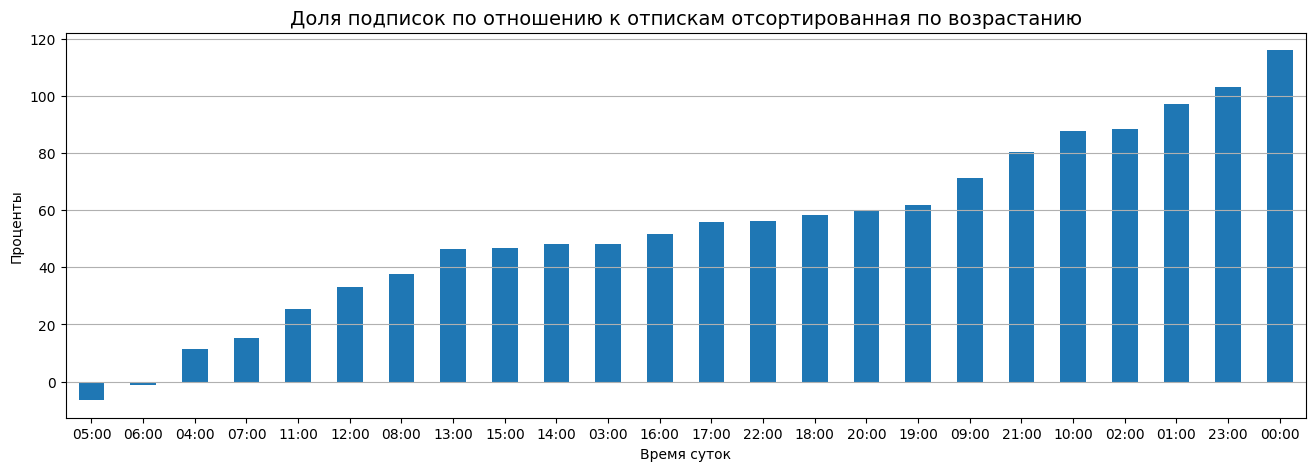

In [41]:
df_pivot['ratio'] = (df_pivot['subscribers']/df_pivot['unsubscribed'] - 1)*100
ax = df_pivot.sort_values(by='ratio', ascending=True).plot(x='time', y='ratio', kind='bar', figsize=(16,5), grid=True, rot=0, legend=False, ylabel='Проценты', xlabel='Время суток');
plt.title('Доля подписок по отношению к отпискам отсортированная по возрастанию', fontsize=14)
ax.xaxis.grid(False)
plt.show();

При более тщательном рассмотрении мы видим, что соотношение подписок и отписок в 5 и 6 часов утра вообще отрицательное, а период наибольшего превалированияя подписок (выше 60%) достигает своего пика в полночь и длится до 2 часов ночи, следующий пик происходит в 9 и 10 утра, и затем в 21 и 23 часа, что наглядно видно на графике ниже:

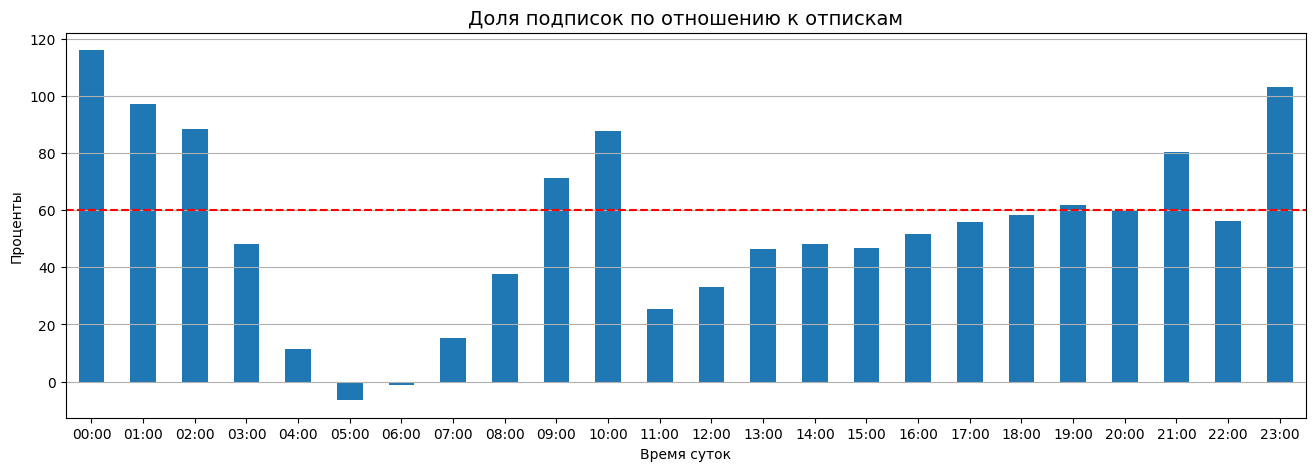

In [42]:
df_pivot['ratio'] = (df_pivot['subscribers']/df_pivot['unsubscribed'] - 1)*100
ax = df_pivot.plot(x='time', y='ratio', kind='bar', figsize=(16,5), grid=True, rot=0, legend=False, ylabel='Проценты', xlabel='Время суток');
plt.title('Доля подписок по отношению к отпискам', fontsize=14)
ax.axhline(y=60, color='r', linestyle='--')
ax.xaxis.grid(False)
plt.show();

Учитывая это знание, целесообразно планировать активность на канале в указанные часы.\
Теперь оценим процессы подписки/отписки применительно к дням недели:

In [43]:
#создаём сводную таблицу
df_pivot_day = df_subs_unsubs_hous.pivot_table(index='day', values = ['subscribers', 'unsubscribed'], aggfunc='sum')

#отсортируем дни недели в соответвии с их порядком следования
df_pivot_day = df_pivot_day.reset_index()

# Создаем словарь c порядковыми номерами дней недели
day_order = {'Пн': 1, 'Вт': 2, 'Ср': 3, 'Чт': 4, 'Пт': 5, 'Сб': 6, 'Вс': 7}

# Сортировка DataFrame в соответствии с порядком дней недели
df_pivot_day = df_pivot_day.loc[df_pivot_day['day'].map(day_order).sort_values().index].reset_index(drop=True)


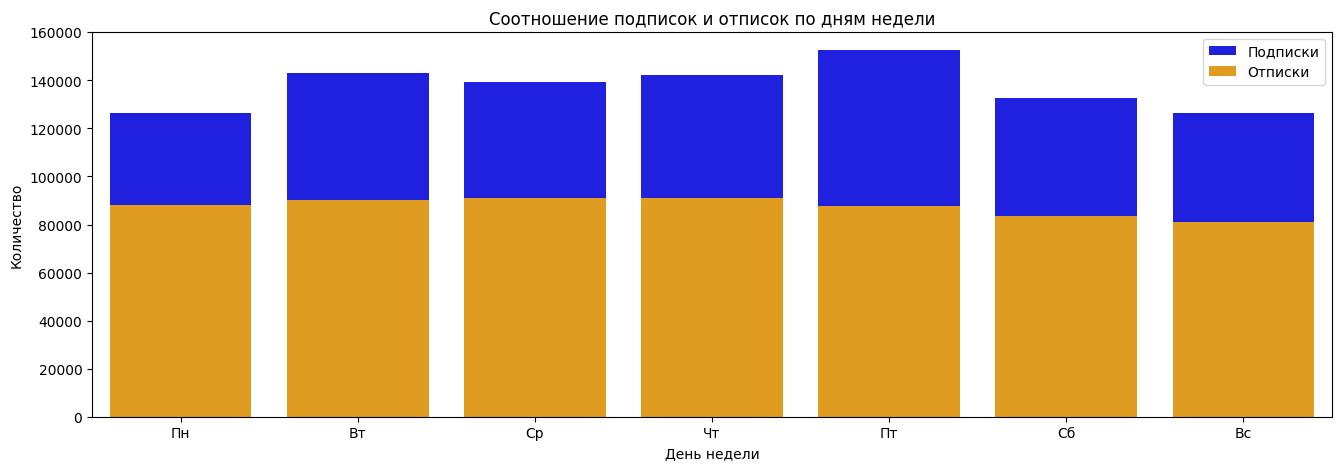

In [44]:
# меняем знак на противоположный unsubscribed
df_pivot_day['unsubscribed'] = df_pivot_day['unsubscribed'] * -1

# Построение столбчатой диаграммы
plt.figure(figsize=(16, 5))
sns.barplot(data=df_pivot_day, x='day', y='subscribers', color='blue', label='Подписки')
sns.barplot(data=df_pivot_day, x='day', y='unsubscribed', color='orange', label='Отписки')
plt.xlabel('День недели')
plt.ylabel('Количество')
plt.title('Соотношение подписок и отписок по дням недели')
plt.legend()
plt.show()
plt.show()

Как ни странно, количество отписок во все дни недели примерно одинаковое, однако их доля по отношению к подпискам всё же отличается. Оценим это:

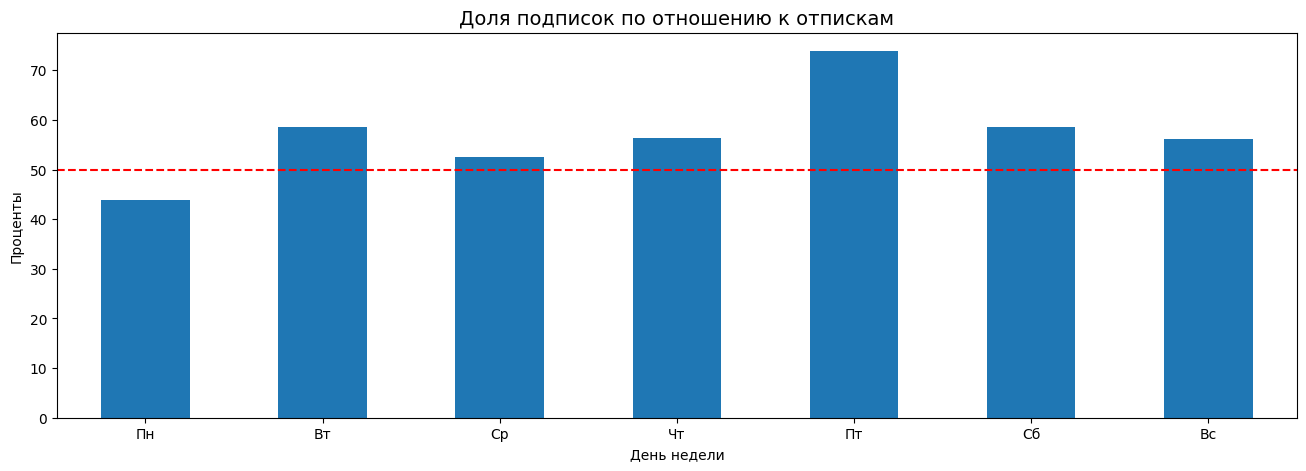

In [45]:
#смотрим долю подписок по отношению к отпискам по дням недели
df_pivot_day['ratio'] = (df_pivot_day['subscribers']/df_pivot_day['unsubscribed'] - 1)*100

ax = df_pivot_day.plot(x='day', y='ratio', kind='bar', figsize=(16,5), grid=False, rot=0, legend=False, ylabel='Проценты', xlabel='День недели');
plt.title('Доля подписок по отношению к отпискам', fontsize=14)
ax.axhline(y=50, color='r', linestyle='--')
plt.show();

Соотношение подписок к отпискам наихудшее в понедельник - в этот день подписки превалируют над отписками всего на 40%, однако, следует иметь виду, что это не за счёт большего количества отписок, а просто в этот день меньше подписываются. Наилучший результат даёт вторник, пятница и суббота, с безусловным лидированием пятницы. Эти данные можно использовать при планировании размещения контента. В любом случае, наиболее неудачными днями, согласно имеющейся статистики, является понедельник и среда.

### Анализ показателей постов

#### Динамика количества просмотров, пересылок, комментариев и эмоциональных реакций



Непосредственными характеристиками постов у нас являются количество просмотров, пересылок, эмоциональных реакций и типа используемого вложения (видео, изображение, ссылка). Поскольку нас интересует не только эффективность каждого отдельного поста, но и канала в целом, посмотрим, как себя вели количественные показатели публикаций в границах рассматриваемого периода в среднем за сутки.\
*Здесь и далее мы будем брать именно среднее арифметическое, а не медианное значение показателей, поскольку, во-первых, их пиковые значения являются не неким случайным статистическим отклонением, а являются следствием деятельности канала, следовательно, подлежат учёту, и, во-вторых, анализ проводится на достаточно большом периоде времени, что предполагает минимизацию влияния "пиковых значений" на общую картину*:

In [46]:
#выделим из столбца date только дату
df_posts['yyyy_mm_dd'] = pd.to_datetime(df_posts['date']).dt.floor('d')


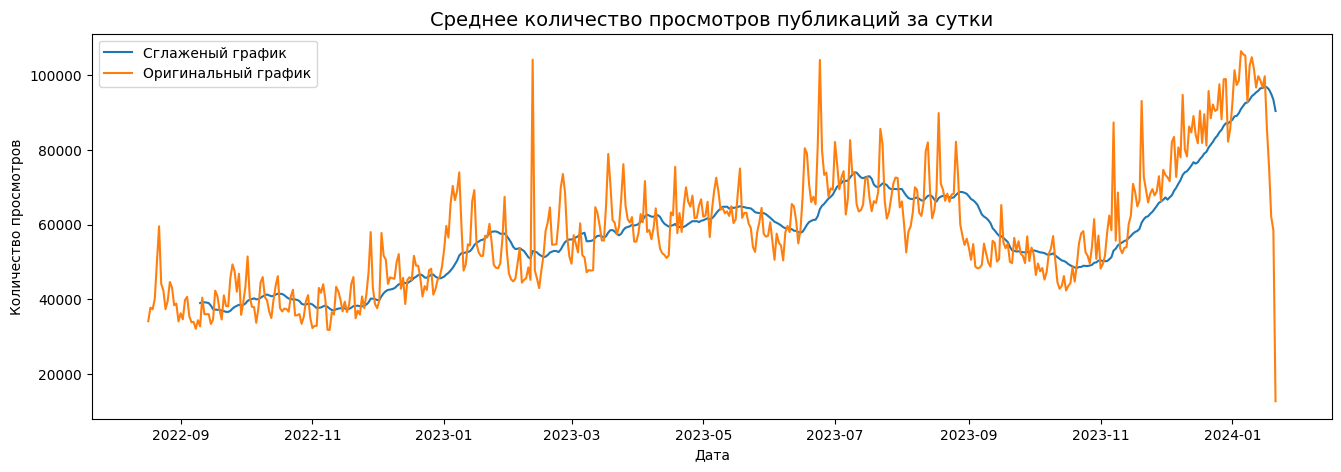

In [47]:
# Создание сводной таблицы со сглаживанием и без сглаживания
smoothed_data = df_posts.pivot_table(index='yyyy_mm_dd', values=['views'], aggfunc='mean').rolling(25).mean()
original_data = df_posts.pivot_table(index='yyyy_mm_dd', values=['views'], aggfunc='mean')

# Построение графика с двумя линиями
plt.figure(figsize=(16, 5))
plt.plot(smoothed_data.index, smoothed_data['views'], label='Сглаженый график')
plt.plot(original_data.index, original_data['views'], label='Оригинальный график')
plt.title('Среднее количество просмотров публикаций за сутки', fontsize=14)
plt.xlabel('Дата')
plt.ylabel('Количество просмотров')
plt.legend()
plt.show()

На усреднённом сглаженном графике можно заметить уже обозначенные нами тенденции, выявленные при анализе изменения количества подписчиков. Все основные фазы коррелируют с изменением количества подписчиков. Особенно чётко виден период спада просмотров с конца августа по начало ноября 2023 года - он полностью совпадает с откатом в числе подписчиков в тот же период.\
Установим даты самых ярких всплесков среднего числа просмотров за сутки. Так как даты в районе нового года нам не очень интересны, найдём соответвующие максимумы просмотров, которые были ранее 1 ноября 2023 года:


In [48]:
original_data.query('views > 82500 and index < "2023-11-01"').reset_index()

yyyy_mm_dd          views
0 2023-02-11  104154.857143
1 2023-06-24  104079.000000
2 2023-07-08   82605.166667
3 2023-07-22   85622.250000
4 2023-08-18   89854.166667

Теперь посмотрим на другие средние количественные показатели публикаций в сутки:

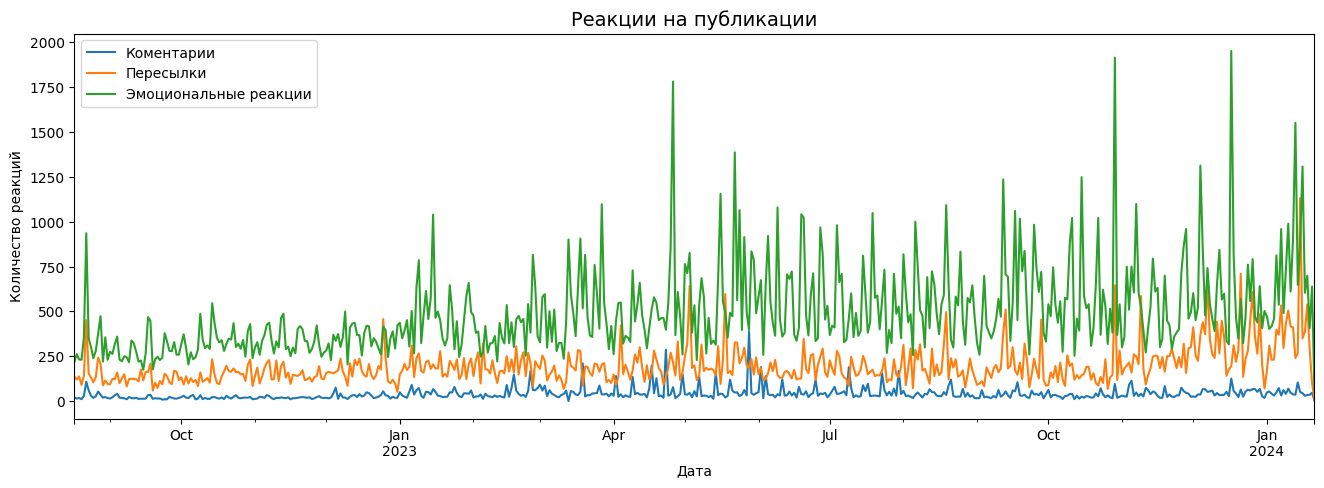

In [49]:
#графики средних показателей постов
df_posts.pivot_table(index='yyyy_mm_dd', values=['forwarded', 'reactions_count',
                                                 'comments'], aggfunc='mean').plot(figsize=(16, 5), ylabel='Количество реакций', xlabel='Дата');
plt.title('Реакции на публикации', fontsize=14);
plt.legend(['Коментарии', 'Пересылки', 'Эмоциональные реакции'])
plt.show;

Вопреки ожиданиям, мы видим, что среднее число пересылок и комментариев не всегда совпадает с "эмоциональными всплесками" подписчиков. Предположительно это вызвано тем, что иногда Канал использует эмотиконы для голосования, в связи с чем "эмоции" не отражаются на других реакциях пользователей.
Выделим несколько дат, в которые наблюдались особенно большое среднее количество реакций в сутки:

In [50]:
#среднее количество эмоциональных реакций
df_posts.pivot_table(index='yyyy_mm_dd', values=['forwarded', 'reactions_count', 'comments'], aggfunc='mean').query('reactions_count > 1350')[['reactions_count']].reset_index()

yyyy_mm_dd  reactions_count
0 2023-04-26      1781.285714
1 2023-05-22      1386.714286
2 2023-10-29      1914.833333
3 2023-12-17      1951.500000
4 2024-01-13      1551.600000

In [51]:
#среднее количество пересылок
df_posts.pivot_table(index='yyyy_mm_dd', values=['forwarded', 'reactions_count', 'comments'], aggfunc='mean').query('forwarded > 600')[['forwarded']].reset_index()

yyyy_mm_dd    forwarded
0 2023-05-03   641.000000
1 2023-10-29   645.833333
2 2023-12-07   663.000000
3 2023-12-21   709.250000
4 2023-12-26   607.857143
5 2024-01-15  1131.666667

In [52]:
#среднее количество комментариев
df_posts.pivot_table(index='yyyy_mm_dd', values=['forwarded', 'reactions_count', 'comments'], aggfunc='mean').query('comments > 180')[['comments']].reset_index()

yyyy_mm_dd    comments
0 2023-03-19  209.333333
1 2023-04-17  196.666667
2 2023-04-23  285.750000
3 2023-05-28  385.666667
4 2023-06-02  189.000000
5 2023-07-09  188.333333

Для облегчения восприятия существующих тенденций выведем сглаженные усреднённые графики:

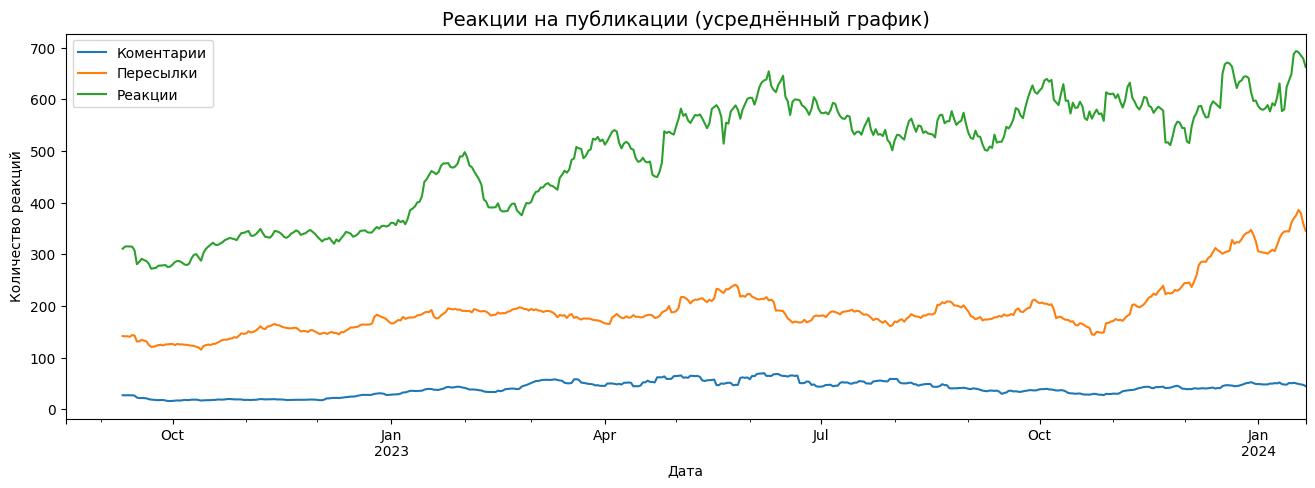

In [53]:
#сглаженные графики средних показателей постов
df_posts.pivot_table(index='yyyy_mm_dd', values=['forwarded', 'reactions_count',
                                                 'comments'], aggfunc='mean').rolling(25).mean().plot(figsize=(16, 5), ylabel='Количество реакций', xlabel='Дата');
plt.title('Реакции на публикации (усреднённый график)', fontsize=14);
plt.legend(['Коментарии', 'Пересылки', 'Реакции'])
plt.show;

На графиках мы видим чёткую связь между средним числом пересылок в сутки с последним всплеском увеличения подписчиков середины ноября 2023 года.\
Что касается эмоциональных реакций, несмотря на их общую теденцию к увеличению, четкой зависимости от изменения числа подписчиков всё же не проматривается, хотя в целом увеличение среднего количества эмоциональных реакций с ростом количества подписчиков налицо. Более того, в период стагнации с ростом числа подписчиков с марта до середины июня, напротив, отмечается рост среднего количества реакция в сутки.\
Что касается среднего числа комментариев в сутки, то оно остаётся практически на одном уровне, независимо от процессов подписки/отписки и других проявлений активности пользователей. Можно предположить, что комментаторами канала является некое неизменное ядро активных пользователей, которые живут своей жизнью, мало зависящей от усилий команды Кинопоиска.

#### Изучение динамики постов в зависимости от типов вложения

Посмотрим, существует ли какая-то разница в динамике постов с различным типом вложения (ссылка, видео, изображение)) относительно рассмотренных в предыдущем разделе зарактеристик:

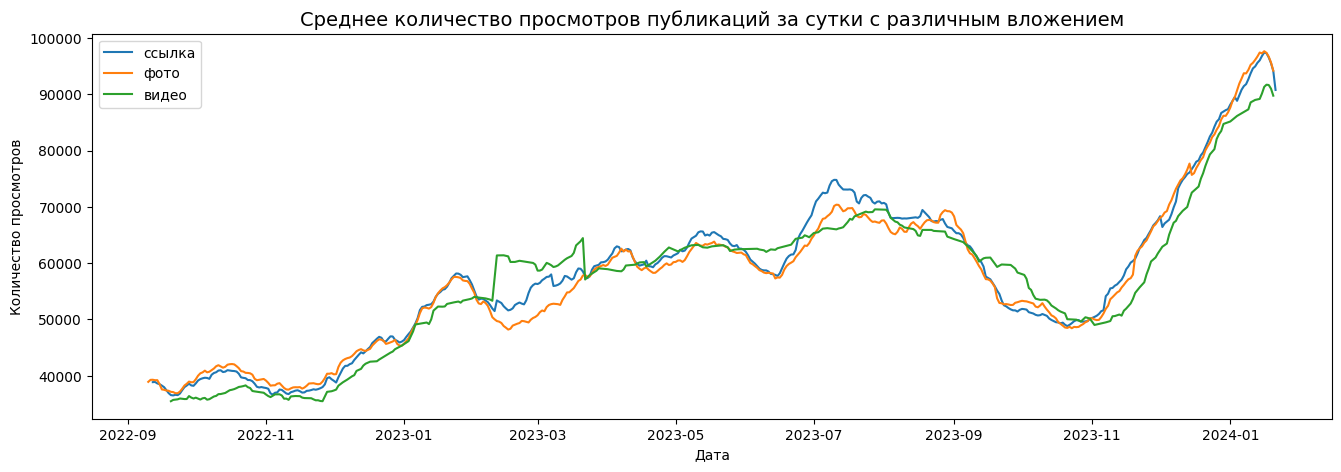

In [54]:
# Создание сводной таблицы со сглаживанием и без сглаживания
data_link = df_posts.query('type_attachment == "ссылка"').pivot_table(index='yyyy_mm_dd', values=['views'], aggfunc='mean').rolling(25).mean()
data_picture = df_posts.query('type_attachment == "фото"').pivot_table(index='yyyy_mm_dd', values=['views'], aggfunc='mean').rolling(25).mean()
data_video = df_posts.query('type_attachment == "видео"').pivot_table(index='yyyy_mm_dd', values=['views'], aggfunc='mean').rolling(25).mean()


# Построение графика с тремя линиями
plt.figure(figsize=(16, 5))
plt.plot(data_link.index, data_link['views'], label='ссылка')
plt.plot(data_picture.index, data_picture['views'], label='фото')
plt.plot(data_video.index, data_video['views'], label='видео')

plt.title('Среднее количество просмотров публикаций за сутки с различным вложением', fontsize=14)
plt.xlabel('Дата')
plt.ylabel('Количество просмотров')
plt.legend()
plt.show()

Соотношение среднего количества просмотров публикаций с видео и фото неоднозначно. Можно отметить, что там, где заметно проседают просмотры с фото, на первый план выходят посты с видео, как. например, в феврале-апреле 2023 года. В то же время нельзя не заметить, что посты со ссылкой в определённые периоды заметно опережают по среднесуточным просмотрам остальные. Однако, возможно, это вызвано тем, что таких постов просто публиковалось больше.

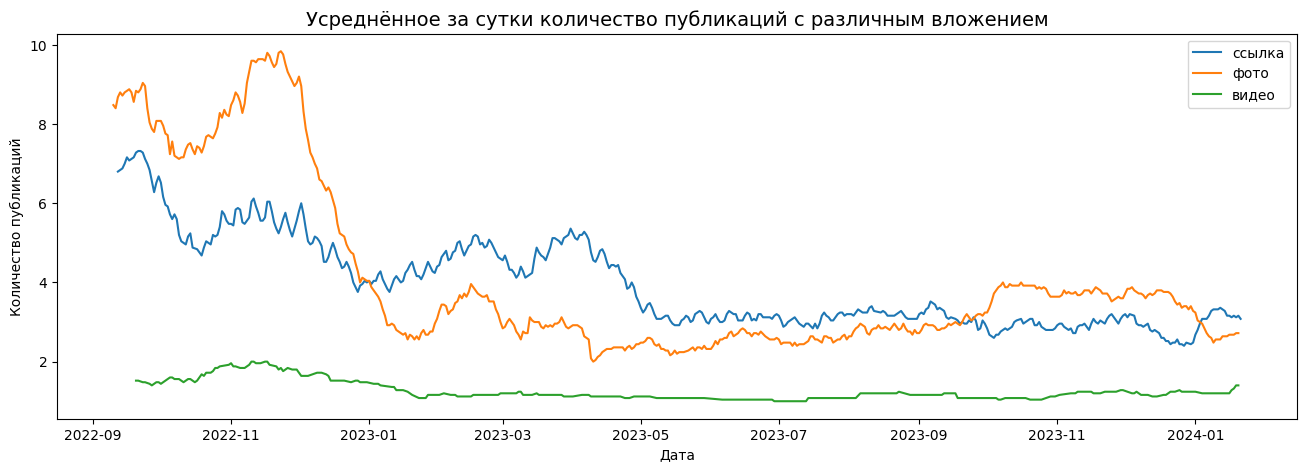

In [55]:
# Создание сводной таблицы со сглаживанием и без сглаживания
data_link = df_posts.query('type_attachment == "ссылка"').pivot_table(index='yyyy_mm_dd', values=['views'], aggfunc='count').rolling(25).mean()
data_picture = df_posts.query('type_attachment == "фото"').pivot_table(index='yyyy_mm_dd', values=['views'], aggfunc='count').rolling(25).mean()
data_video = df_posts.query('type_attachment == "видео"').pivot_table(index='yyyy_mm_dd', values=['views'], aggfunc='count').rolling(25).mean()


# Построение графика с тремя линиями
plt.figure(figsize=(16, 5))
plt.plot(data_link.index, data_link['views'], label='ссылка')
plt.plot(data_picture.index, data_picture['views'], label='фото')
plt.plot(data_video.index, data_video['views'], label='видео')

plt.title('Усреднённое за сутки количество публикаций с различным вложением', fontsize=14)
plt.xlabel('Дата')
plt.ylabel('Количество публикаций')
plt.legend()
plt.show()

Мы видим, что в число публикаций с видео в абсолютных цифрах значительно ниже ссылочного и фото-контента. При этом с января по октябрь количество постов со ссылками превалировало над публикациями с другими вложениями.Можно отметить также в целом уменьшение количества постов с сентября 2022 года май 2022.\
Теперь попробуем увидеть разницу, визуализировав усреднённое количество просмотров на 1 пост:

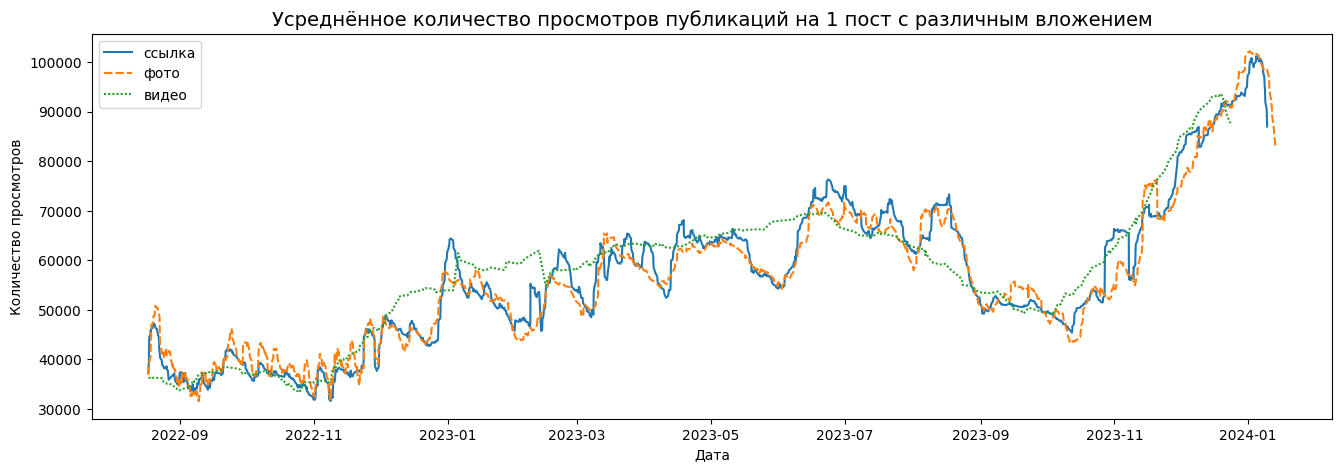

In [56]:
# Фильтрация и усреднение данных
data_link = df_posts.query('type_attachment == "ссылка"')[['date', 'views']].set_index('date').rolling(25).mean()
data_photo = df_posts.query('type_attachment == "фото"')[['date', 'views']].set_index('date').rolling(25).mean()
data_video = df_posts.query('type_attachment == "видео"')[['date', 'views']].set_index('date').rolling(25).mean()

# Объединение данных для построения графика
merged_data = pd.concat([data_link['views'], data_photo['views'], data_video['views']], axis=1)
merged_data.columns = ['ссылка', 'фото', 'видео']

# Создание графика с помощью Seaborn
plt.figure(figsize=(16, 5))
sns.lineplot(data=merged_data)
plt.title('Усреднённое количество просмотров публикаций на 1 пост с различным вложением', fontsize=14)
plt.xlabel('Дата')
plt.ylabel('Количество просмотров')
plt.show()

Мы видим, что в разные периоды за зрительское внимание конкурируют посты с различным вложением, однако, в целом можно отметить тот факт, что на этапе общего подъёма просмотров больше внимания привлекают посты с видеоконтентом, и наоборот, на этапе спада, например, с конца июня по середину октября 2023 года, лидируют посты со ссылками и фото. Есть предположение, что преобладание постов со ссылками в этот период как по числу так и по просмотрам привело к тому, что люди стали уходить на сторонние ресурсы, на которые вели эти ссылки, что со временем привело к падению просмотров, а затем и подписки.\
Узнаем, сколько просмотров в среднем привлекли посты с различным вложением за весь исследуемый период:

In [57]:
print('Среднее количество просмотров постов фото:', int(data_photo.mean()[0]))
print('Среднее количество просмотров постов со ссылками:', int(data_link.mean()[0]))
print('Среднее количество просмотров постов с видео:', int(data_video.mean()[0]))

Среднее количество просмотров постов фото: 51316
Среднее количество просмотров постов со ссылками: 53885
Среднее количество просмотров постов с видео: 54216


Разница выглядит незначительной, но, всё-таки следует отметить, что в среднем большее количество просмотров приходится на видеоконтент, а наименьшее - на фото.\
Попробуем выяснить, какой контент вызывает больше эмоциональных реакций:

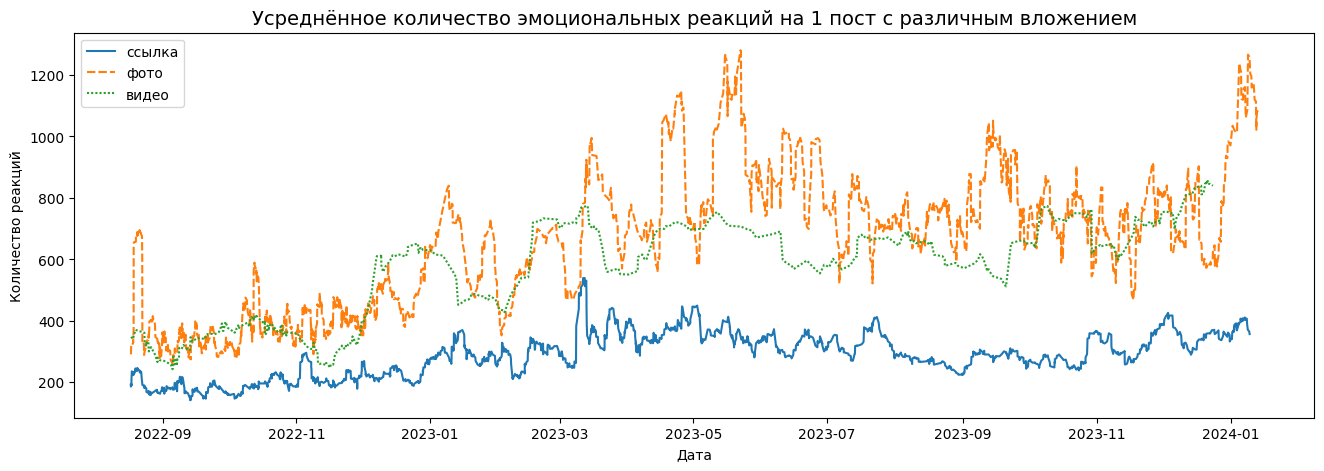

In [58]:
# Фильтрация и усреднение данных
data_link = df_posts.query('type_attachment == "ссылка"')[['date', 'reactions_count']].set_index('date').rolling(25).mean()
data_photo = df_posts.query('type_attachment == "фото"')[['date', 'reactions_count']].set_index('date').rolling(25).mean()
data_video = df_posts.query('type_attachment == "видео"')[['date', 'reactions_count']].set_index('date').rolling(25).mean()

# Объединение данных для построения графика
merged_data = pd.concat([data_link['reactions_count'], data_photo['reactions_count'], data_video['reactions_count']], axis=1)
merged_data.columns = ['ссылка', 'фото', 'видео']

# Создание графика с помощью Seaborn
plt.figure(figsize=(16, 5))
sns.lineplot(data=merged_data)
plt.title('Усреднённое количество эмоциональных реакций на 1 пост с различным вложением', fontsize=14)
plt.xlabel('Дата')
plt.ylabel('Количество реакций')
plt.show()

Очевидно, что фотографии лидируют с большим отрывом среди любителей эмотиконов.\
Проверим, какой контент генерирует большее количество пересылок:

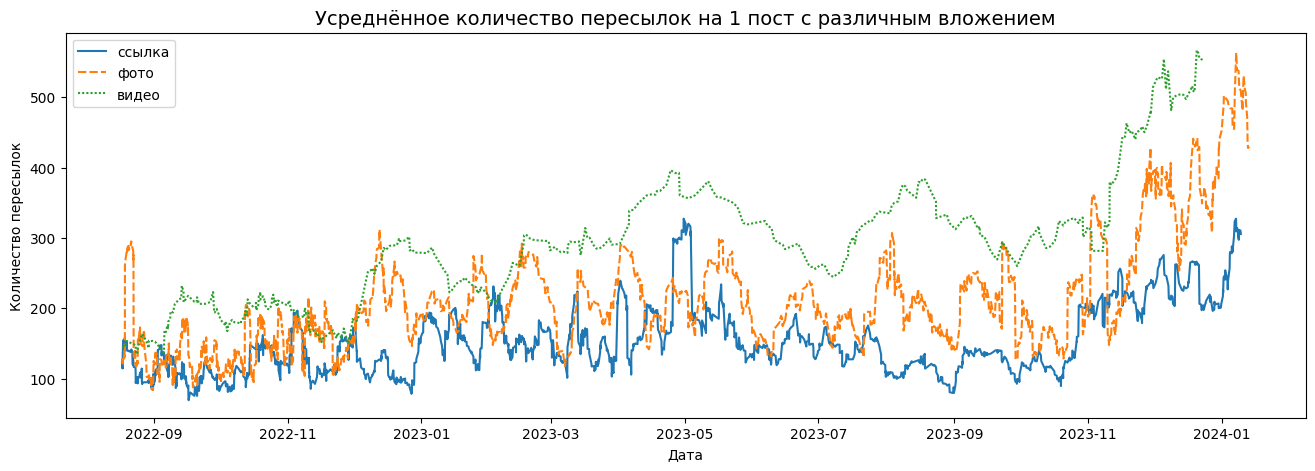

In [59]:
# Фильтрация и усреднение данных
data_link = df_posts.query('type_attachment == "ссылка"')[['date', 'forwarded']].set_index('date').rolling(25).mean()
data_photo = df_posts.query('type_attachment == "фото"')[['date', 'forwarded']].set_index('date').rolling(25).mean()
data_video = df_posts.query('type_attachment == "видео"')[['date', 'forwarded']].set_index('date').rolling(25).mean()

# Объединение данных для построения графика
merged_data = pd.concat([data_link['forwarded'], data_photo['forwarded'], data_video['forwarded']], axis=1)
merged_data.columns = ['ссылка', 'фото', 'видео']

# Создание графика с помощью Seaborn
plt.figure(figsize=(16, 5))
sns.lineplot(data=merged_data)
plt.title('Усреднённое количество пересылок на 1 пост с различным вложением', fontsize=14)
plt.xlabel('Дата')
plt.ylabel('Количество пересылок')
plt.show()

А вот пересылки продуцирует в большей степени видеоконтент. Следовательно, именно медиаконтент обладает наибольшей виральностью.\
Узнаем, что вызывает наибольшее количество комментариев:

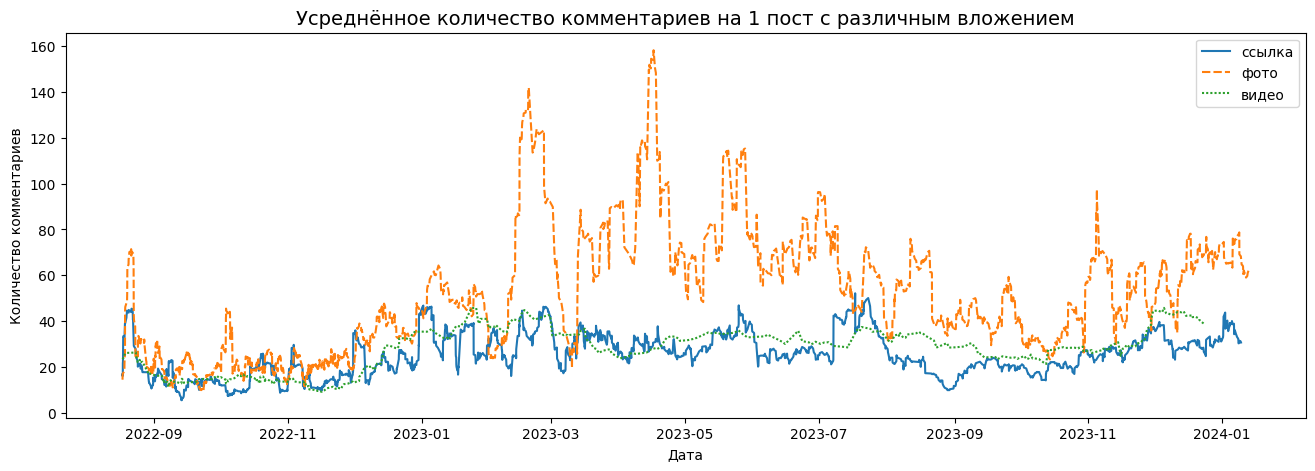

In [60]:
# Фильтрация и усреднение данных
data_link = df_posts.query('type_attachment == "ссылка"')[['date', 'comments']].set_index('date').rolling(25).mean()
data_photo = df_posts.query('type_attachment == "фото"')[['date', 'comments']].set_index('date').rolling(25).mean()
data_video = df_posts.query('type_attachment == "видео"')[['date', 'comments']].set_index('date').rolling(25).mean()

# Объединение данных для построения графика
merged_data = pd.concat([data_link['comments'], data_photo['comments'], data_video['comments']], axis=1)
merged_data.columns = ['ссылка', 'фото', 'видео']

# Создание графика с помощью Seaborn
plt.figure(figsize=(16, 5))
sns.lineplot(data=merged_data)
plt.title('Усреднённое количество комментариев на 1 пост с различным вложением', fontsize=14)
plt.xlabel('Дата')
plt.ylabel('Количество комментариев')
plt.show()

Можно констатировать, что наибольшее количество комментариев появляется под фотографиями.

#### Изучение динамики постов в зависимости от объёма и сложности текста

Посчитаем количество слов в каждом посте:

In [61]:
#считаем количество слов в публикации
df_posts['text_amount'] = df_posts['text'].apply(lambda x: len(str(x).split()))

Теперь количество знаков пунктуации (=сложность текста) и количество ссылок в публикации:

In [62]:
#создаём функию для подсчёта количества знаков в публикации (сложность текста) и количества ссылок
def count_punctuation_and_links(text):
    cleaned_text = re.sub(r'http[s]?://\S+', '', text)  # Удаляем все ссылки
    punctuation_count = sum([1 for char in cleaned_text if char in string.punctuation])  # Подсчет знаков препинания
    links_count = len(re.findall(r'http[s]?://\S+', text))  # Подсчет количества ссылок
    return (punctuation_count, links_count)

In [63]:
#считаем сложность текста и количество ссылок в публикации
df_posts['text_difficulty'], df_posts['text_links'] = zip(*df_posts['text'].apply(count_punctuation_and_links))

Таким образом, в датасете со сведениями о постах мы получили 3 новых метрики публикаций:
- 'text_amount' - объём текста;
- 'text_difficulty' - сложность текста;
- 'text_links' - количество ссылок в тексте.\
Попробуем оценить, менялись ли эти параметры на канале с течением времени:

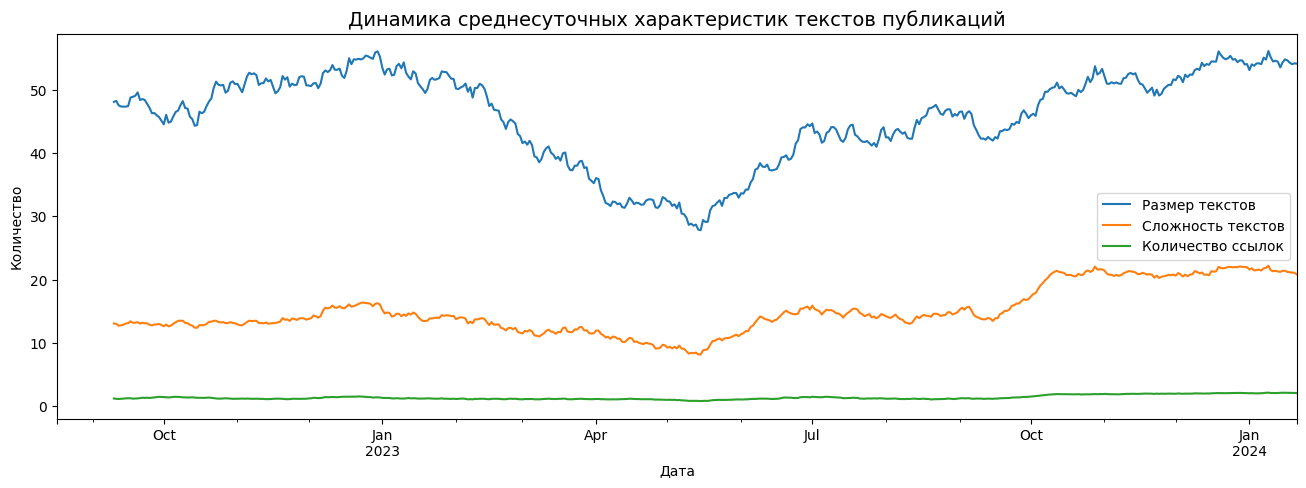

In [64]:
#сглаженные графики средних показателей постов
df_posts.pivot_table(index='yyyy_mm_dd', values=['text_amount', 'text_difficulty',
                                                 'text_links'], aggfunc='mean').rolling(25).mean().plot(figsize=(16, 5), ylabel='Количество', xlabel='Дата');
plt.title('Динамика среднесуточных характеристик текстов публикаций', fontsize=14);
plt.legend(['Размер текстов', 'Сложность текстов', 'Количество ссылок'])
plt.show;

Интересно, что локальный июньский минимум просмотров почти совпадает со среднесуточным минимумом публикуемого в постах текста, а в среднем, количество знаков пунктуации очень хорошо соотносится с объёмом текста, что неудивительно.\
Посмотрим, влияют ли как-то новые характеристики на количество просмотров и другие проявления активности пользователей:

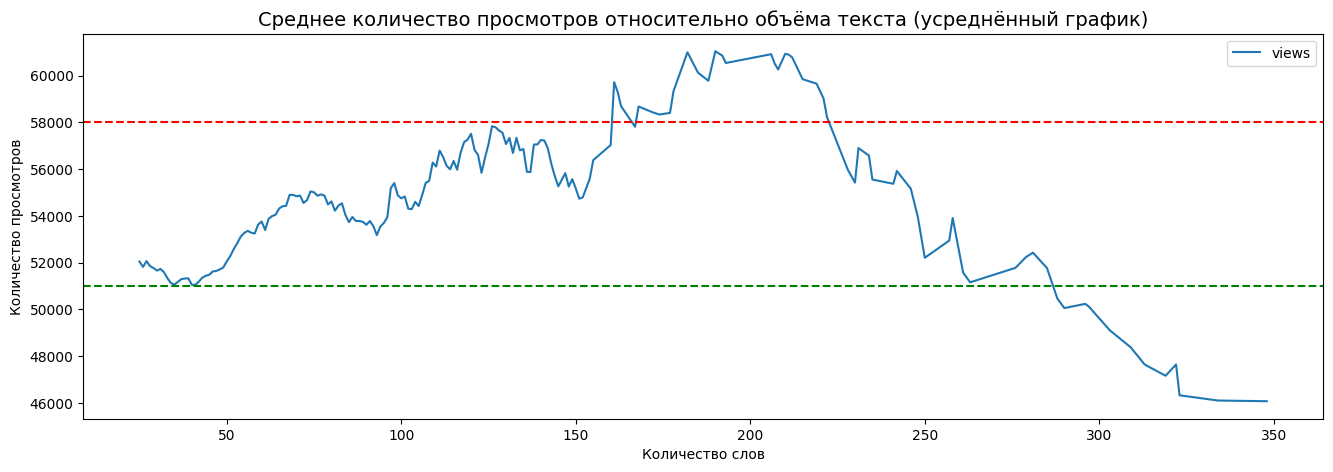

In [65]:
#графики среднего количества просмотров относительно объёма текста
ax = df_posts.pivot_table(index='text_amount', values='views', aggfunc='mean').rolling(25).mean().plot(figsize=(16, 5), ylabel='Количество просмотров', xlabel='Количество слов');
plt.title('Среднее количество просмотров относительно объёма текста (усреднённый график)', fontsize=14);
ax.axhline(y=58000, color='r', linestyle='--')
ax.axhline(y=51000, color='g', linestyle='--')
plt.show;

Исходя из этого графика логично предположить, что оптимальный объём поста, вызывающий наибольший зрительский интерес это примерно 160 - 220 слов. Публикации, имеющие меньше и больше слов менее привлекательны для подписчиков.\
Оценим, какое влияние на просмотры оказывает сложность текста:

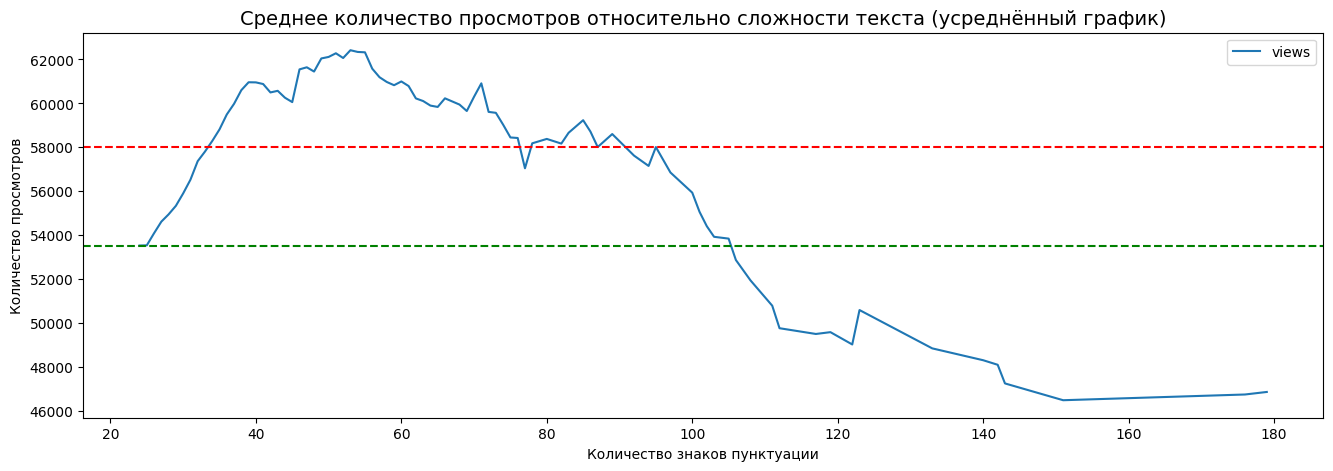

In [66]:
#графики среднего количества просмотров относительно сложности текста
ax = df_posts.pivot_table(index='text_difficulty', values='views', aggfunc='mean').rolling(25).mean().plot(figsize=(16, 5), ylabel='Количество просмотров', xlabel='Количество знаков пунктуации');
plt.title('Среднее количество просмотров относительно сложности текста (усреднённый график)', fontsize=14);
ax.axhline(y=58000, color='r', linestyle='--')
ax.axhline(y=53500, color='g', linestyle='--')
plt.show;

Как и в случае с объёмом текста, наибольший интерес вызывает "золотая середина". В данном случае, она находится в диапазоне 35-95 знаков, после чего следует резкий спад просмотров.\
Исследуем, зависят ли просмотры от количества ссылок в публикации:

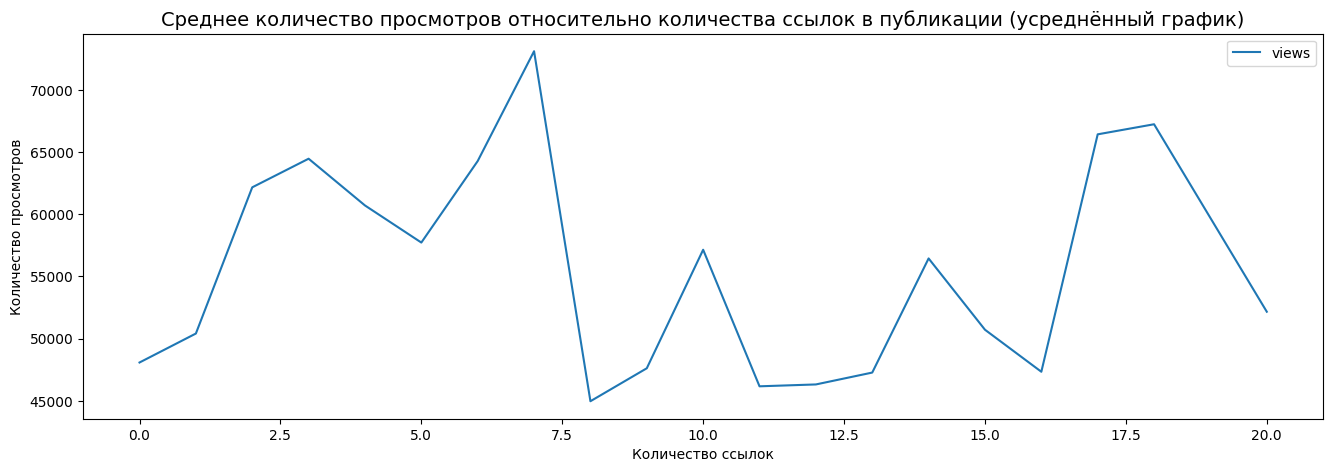

In [67]:
#графики среднего количества просмотров относительно количества ссылок в публикации
ax = df_posts.pivot_table(index='text_links', values='views', aggfunc='mean').rolling(1).mean().plot(figsize=(16, 5), ylabel='Количество просмотров', xlabel='Количество ссылок');
plt.title('Среднее количество просмотров относительно количества ссылок в публикации (усреднённый график)', fontsize=14);
plt.show;

Самую большую цифру средних просмотров дают посты с 7-ю ссылками,после чего следует резкий спад. Последующий максимум на уровне 17 ссылок может быть не валидным в силу недостаточной статистики по таким постам.\
Идеальный пост в свете приведённого графика выглядит таким: от 2 до 7 ссылок, но не пять!\
Вглянем на другие проявления активности пользователей:

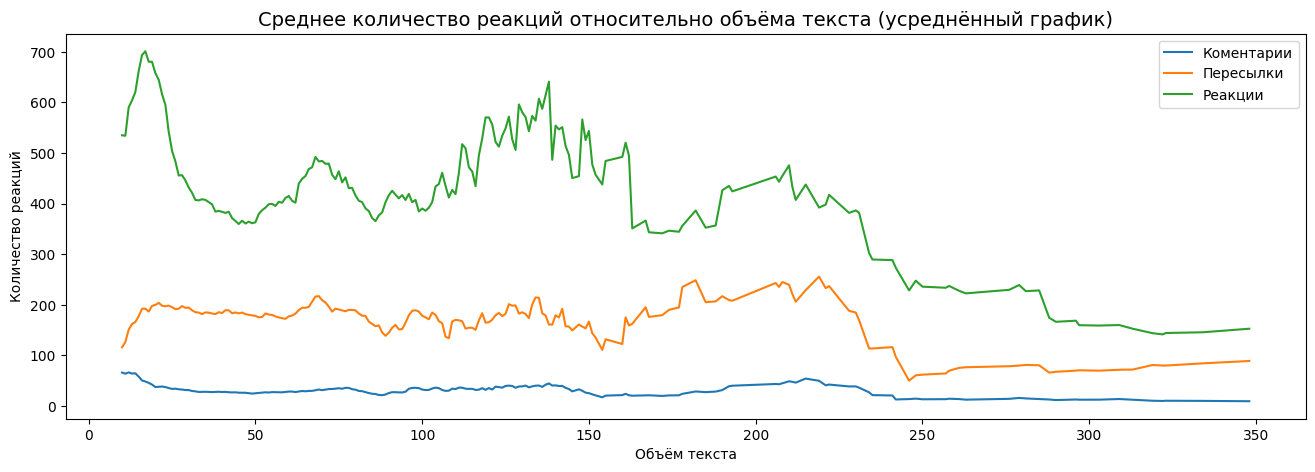

In [68]:
#графики среднего количества реакций относительно объёма текста
df_posts.pivot_table(index='text_amount', values=['forwarded', 'reactions_count',
                                                 'comments'], aggfunc='mean').rolling(10).mean().plot(figsize=(16, 5), ylabel='Количество реакций', xlabel='Объём текста');
plt.title('Среднее количество реакций относительно объёма текста (усреднённый график)', fontsize=14);
plt.legend(['Коментарии', 'Пересылки', 'Реакции'])
plt.show;

Мы видим, что наибольшее количество эмоциональных реакций вызывают посты с объёмом 17 слов, следующий максимум находится в примерное в диапазоне от 120 до 150 слов.\
Что касается пересылок, то здесь неярко выражженный максимум приходится на отрезок от 180 до 220 слов, после чего следует резкое падение. Примерно в этой же точке фиксируется также падение количества эмоциональных реакций.\
Комментарии, как и следовало ожидать, выраженных всплесков не демонстрируют, хотя и здесь можно заметить некоторое падение активности в постах, превышающих 220 слов.\
Проверим картину распределения реакций относительно сложности текста, хотя по предыдущему опыту, она должна быть практически полностью идентичной:

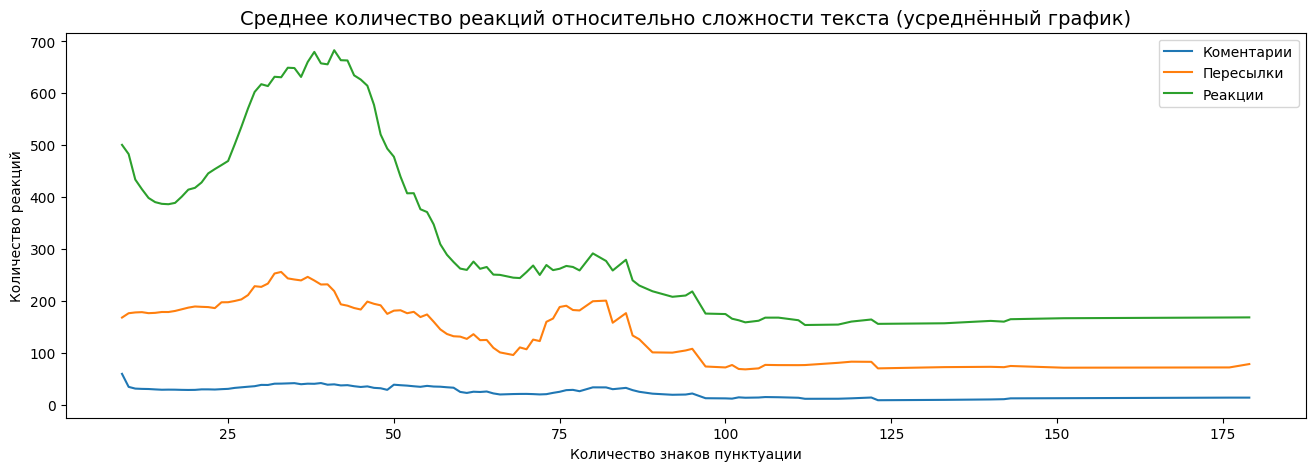

In [69]:
#графики среднего количества реакций относительно сложности текста
df_posts.pivot_table(index='text_difficulty', values=['forwarded', 'reactions_count',
                                                 'comments'], aggfunc='mean').rolling(10).mean().plot(figsize=(16, 5), ylabel='Количество реакций', xlabel='Количество знаков пунктуации');
plt.title('Среднее количество реакций относительно сложности текста (усреднённый график)', fontsize=14);
plt.legend(['Коментарии', 'Пересылки', 'Реакции'])
plt.show;

Картина действительно похожа, хотя выглядит более выраженной. Можно отметить резкий спад откликов на посты, количество пунктуационных знаков в которых превышает 90. Максимум по эмоциям дают посты со "сложностью" 30-50 пунктуационных знаков, менее выраженный максимум по пересылкам у постов в 30-40 знаков, потом следует ещё один локальный всплеск на уровне 70-85 знаков.\
Комментарии традиционно демонстрируют гладкий график.

Исследуем реакции на посты с различным количеством ссылок:

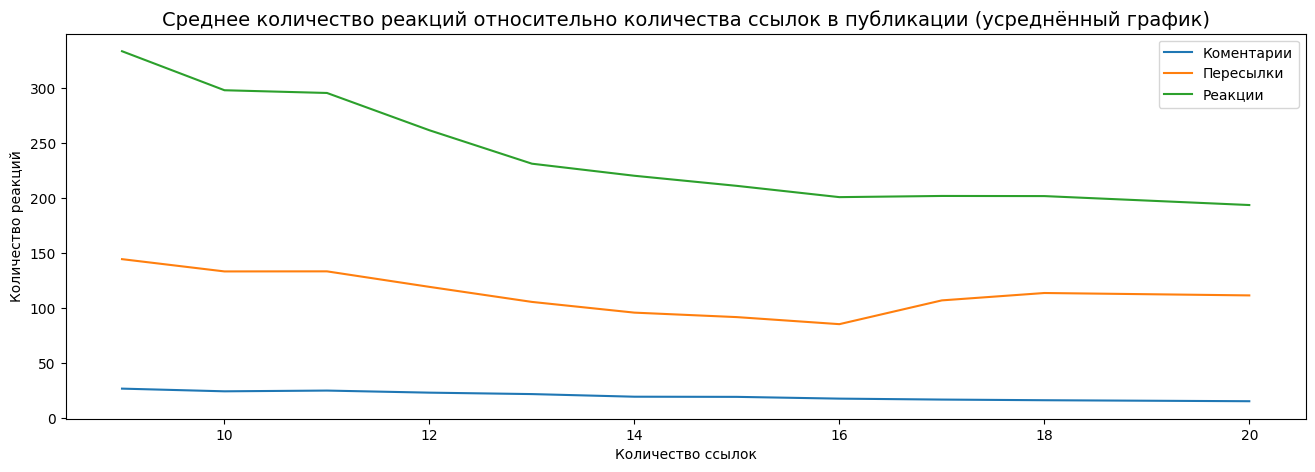

In [70]:
#графики среднего количества реакций относительно количества ссылок в публикации
df_posts.pivot_table(index='text_links', values=['forwarded', 'reactions_count',
                                                 'comments'], aggfunc='mean').rolling(10).mean().plot(figsize=(16, 5), ylabel='Количество реакций', xlabel='Количество ссылок');
plt.title('Среднее количество реакций относительно количества ссылок в публикации (усреднённый график)', fontsize=14);
plt.legend(['Коментарии', 'Пересылки', 'Реакции'])
plt.show;

Обилие ссылок вызывает падение всех реакций, за исключением пересылок - до уровня 16 мы действительно наблюдаем неуклонный спад реакций, но посты в 17-20 ссылок вновь начинают волновать пользователей, но как мы уже отмечали ранее, эти данные могут быть не валидны из-за ограниченности статистики по "суперлинковым" постам. В остальном же, чем больше ссылок, тем менее выражены реакции на пост.

#### Динамика показателей вовлечённости по просмотрам и взаимодействиям (ERR и ER)

Оценим, как менялись показатели вовлечённости подписчиков Кинопоиска в рассматриваемый нами временной период.\
Сначала рассчитаем эти метрики и включим их в датасет со сведениями о постах:

In [71]:
#присоединяем к df_posts датасет с данными по количеству подписчиков df_subs_days для расчёта
df_posts = df_posts.merge(df_subs_days, left_on='yyyy_mm_dd', right_on='date', how='left')

#суммируем реакции
df_posts['sum_actions'] = df_posts['forwarded'] + df_posts['reactions_count'] + df_posts['comments']

#вычисляем метрики
df_posts['err'] = df_posts['views'] / df_posts['subscribers']*100
df_posts['er'] = df_posts['sum_actions'] / df_posts['views'] * 100

#удаляем лишнюю колонку со временем, образовавшуюся из-за слияния таблиц
df_posts.drop('date_y', axis=1, inplace=True)

#возвращаем прежнее имя колонке date
df_posts.rename(columns={'date_x': 'date'}, inplace=True)

Теперь оценим динамику показателей вовлечённости. Для удобства выведем обе линии на один график в разных масштабах:

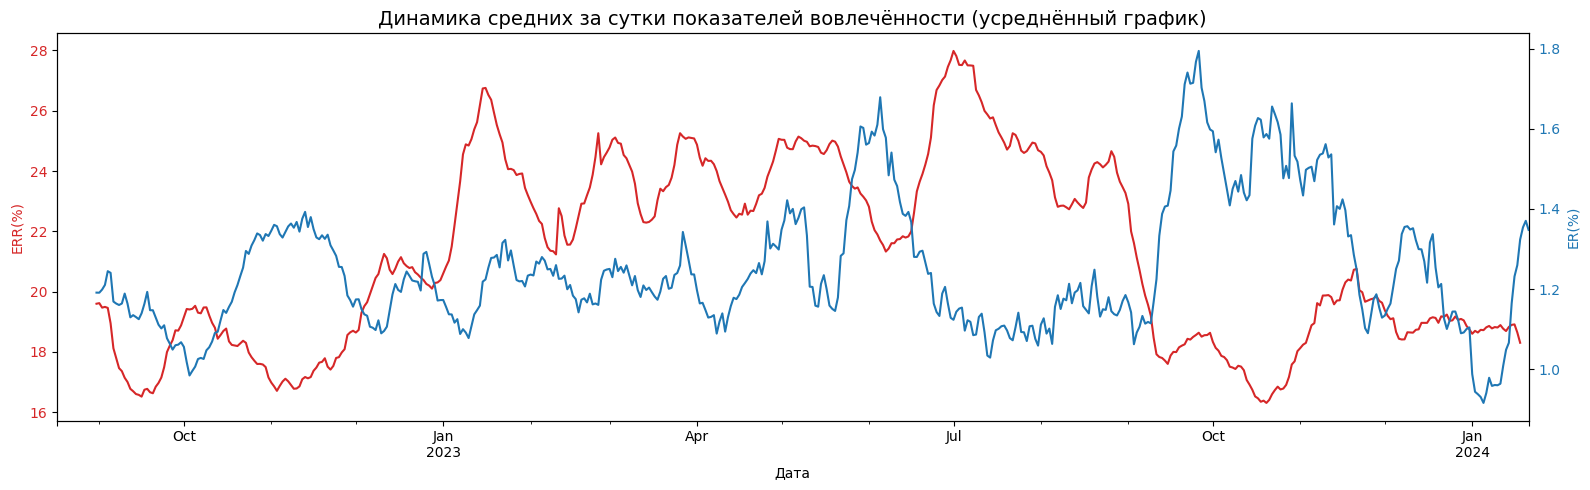

In [72]:
fig, ax1 = plt.subplots(figsize=(16, 5))

color = 'tab:red'
ax1.set_xlabel('Дата')
ax1.set_ylabel('ERR(%)', color=color)
df_posts.pivot_table(index='yyyy_mm_dd', values=['err'], aggfunc='mean').rolling(15).mean().plot(ax=ax1, color=color, label='ERR(%)', xlabel='Дата')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('ER(%)', color=color)
df_posts.pivot_table(index='yyyy_mm_dd', values=['er'], aggfunc='mean').rolling(15).mean().plot(ax=ax2, color=color, label='ER(%)')
ax2.tick_params(axis='y', labelcolor=color)

# Убираем легенду
ax1.legend().set_visible(False)
ax2.legend().set_visible(False)

plt.title('Динамика средних за сутки показателей вовлечённости (усреднённый график)', fontsize=14);
fig.tight_layout()
plt.show()

Практически в течение всего рассматриваемого временного периода мы видим разнонаправленное движение двух показателей вовлечёности - если растёт один, то падает другой, причём в зависимости, близкой к обратно пропорциональной. Это можно объяснить, например, наличием у телеграмм-канала Кинопоиск малоизменяемого по численности ядра подписчиков, активно взаимодействующего с контентом. В этом случае, при падении общего числа просмотров, показатель ER будет неизбежно расти, что мы и видим, сопоставив падение просмотров с сентября по ноябрь 2023 года с ростом показателя ER в тот же период. В момент, когда на канал происходит нашествие неподписывающихся зрителей ER должен расти и в тоже время ERR может падать, что будет являться показателем того, что на канал приходят "случайные" зрители, не желающие связывать себя с каналом, а потому не склонные как-то реагировать на выкладываемый контент. В момент, когда происходит массовая подписка будет падать также и показатель ERR, что будет говорить о том что пришедшие пользователи не интересуются содержанием канала, а попали туда по другой причине, поэтому даже возросшее число просмотров не будет компенсировать долю общего числа неактивных подписчиков. В принципе, на графике, приведённом выше, именно такую картину по ERR мы и наблюдаем, начиная с середины января.

#### Анализ использования эмотиконов

Посчитаем количество разновидностей эмотиконов, использованных в телеграмм канале Кинопоиск за взятый нами период:

In [73]:
print('Всего разновидностей использованных эмотиконов:', len(df_posts[['❤', '👍', '🐳', '👎', '❤‍🔥', '💅', '🔥', '🤪','🍌', '😱', '⚡', '🏆', '🍾', '🤝', '🦄', '🥰', '😁',
'🤩', '🍓', '💋', '👀', '💯','🤬', '😢', '💘', '💔', '👻', '👏', '🕊', '😈', '😍', '🌭', '😭', '🙏', '🎉', '🎃','🤗', '🎄', '😎', '😘', '🤯', '👾', '🤣', '🗿', '🙈', '🌚',
'🆒', '😴', '☃', '🤔', '🥱', '😐', '🎅', '👌', '💩', '🤮', '🖕', '🤡', '🤨', '🥴']].columns))

Всего разновидностей использованных эмотиконов: 60


Выясним, в каком соотношении они применялись. Поскольку в Colab существуют проблемы с установкой шрифтов с эмодзи в matplotlib, воспользуемся библиотекой plotly:

In [74]:
# Создание DataFrame с данными
data = {
    'emoji': ['❤', '👍', '🐳', '👎', '❤‍🔥', '💅', '🔥', '🤪','🍌', '😱', '⚡', '🏆', '🍾', '🤝', '🦄', '🥰', '😁', '🤩', '🍓', '💋', '👀', '💯','🤬', '😢', '💘', '💔',
              '👻', '👏', '🕊', '😈', '😍', '🌭', '😭', '🙏', '🎉', '🎃','🤗', '🎄', '😎', '😘', '🤯', '👾', '🤣', '🗿', '🙈', '🌚', '🆒', '😴', '☃', '🤔', '🥱', '😐',
              '🎅', '👌', '💩', '🤮', '🖕', '🤡', '🤨', '🥴'],
    'count': ((df_posts[['❤', '👍', '🐳', '👎', '❤‍🔥', '💅', '🔥', '🤪','🍌', '😱', '⚡', '🏆', '🍾', '🤝', '🦄', '🥰', '😁', '🤩', '🍓', '💋', '👀', '💯','🤬', '😢', '💘', '💔',
          '👻', '👏', '🕊', '😈', '😍', '🌭', '😭', '🙏', '🎉', '🎃','🤗', '🎄', '😎', '😘', '🤯', '👾', '🤣', '🗿', '🙈', '🌚', '🆒', '😴', '☃', '🤔', '🥱', '😐',
          '🎅', '👌','💩', '🤮', '🖕', '🤡', '🤨', '🥴']].sum().div(df_posts[['❤', '👍', '🐳', '👎', '❤‍🔥', '💅', '🔥', '🤪','🍌', '😱', '⚡', '🏆', '🍾', '🤝', '🦄', '🥰', '😁', '🤩', '🍓', '💋', '👀', '💯','🤬', '😢', '💘', '💔',
          '👻', '👏', '🕊', '😈', '😍', '🌭', '😭', '🙏', '🎉', '🎃','🤗', '🎄', '😎', '😘', '🤯', '👾', '🤣', '🗿', '🙈', '🌚', '🆒', '😴', '☃', '🤔', '🥱', '😐',
          '🎅', '👌','💩', '🤮', '🖕', '🤡', '🤨', '🥴']].sum().sum())) *100).round(1)
}

df_emoji = pd.DataFrame(data)

# Сортировка данных по количеству реакций
df_emoji_sorted = df_emoji.sort_values(by='count', ascending=False)

# Создание графика в Plotly
fig = px.bar(df_emoji_sorted, x='emoji', y='count')
fig.update_layout(title='Процент использования эмотиконов', yaxis_title='% использования')
fig.show()

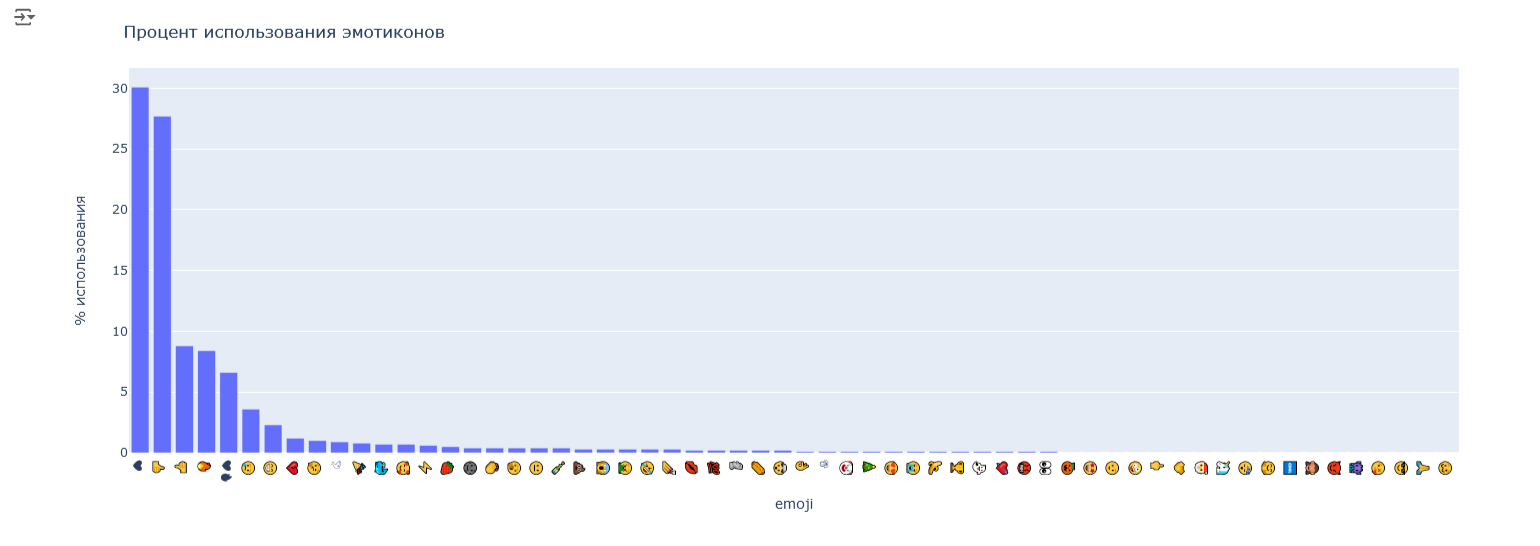

In [75]:
# Отображаем изображение для github
display(Image(filename="/content/drive/MyDrive/Colab Notebooks/graph.png"))

Очевидно, что с большим отрывом лидируют '❤', '👍': 30 и 28 процентов соответсвенно. Посчитаем, сколько приходится на первую десятку:

In [76]:
print('Процент использования первой десятки эмотиконов:', ((df_posts[['❤', '👍', '🐳', '👎', '❤‍🔥', '💅', '🔥', '🤪','🍌', '😱', '⚡', '🏆', '🍾', '🤝', '🦄', '🥰', '😁', '🤩', '🍓', '💋', '👀', '💯','🤬', '😢', '💘', '💔',
          '👻', '👏', '🕊', '😈', '😍', '🌭', '😭', '🙏', '🎉', '🎃','🤗', '🎄', '😎', '😘', '🤯', '👾', '🤣', '🗿', '🙈', '🌚', '🆒', '😴', '☃', '🤔', '🥱', '😐',
          '🎅', '👌','💩', '🤮', '🖕', '🤡', '🤨', '🥴']].sum().sort_values(ascending=False).div(df_posts[['❤', '👍', '🐳', '👎', '❤‍🔥', '💅', '🔥', '🤪','🍌', '😱', '⚡', '🏆', '🍾', '🤝', '🦄', '🥰', '😁', '🤩', '🍓', '💋', '👀', '💯','🤬', '😢', '💘', '💔',
          '👻', '👏', '🕊', '😈', '😍', '🌭', '😭', '🙏', '🎉', '🎃','🤗', '🎄', '😎', '😘', '🤯', '👾', '🤣', '🗿', '🙈', '🌚', '🆒', '😴', '☃', '🤔', '🥱', '😐',
          '🎅', '👌','💩', '🤮', '🖕', '🤡', '🤨', '🥴']].sum().sum())) *100).to_frame().T.iloc[:, :10].sum(axis=1)[0].round(1))

Процент использования первой десятки эмотиконов: 90.7


Посмотрим, что это за эмодзи:

In [77]:
((df_posts[['❤', '👍', '🐳', '👎', '❤‍🔥', '💅', '🔥', '🤪','🍌', '😱', '⚡', '🏆', '🍾', '🤝', '🦄', '🥰', '😁', '🤩', '🍓', '💋', '👀', '💯','🤬', '😢', '💘', '💔',
          '👻', '👏', '🕊', '😈', '😍', '🌭', '😭', '🙏', '🎉', '🎃','🤗', '🎄', '😎', '😘', '🤯', '👾', '🤣', '🗿', '🙈', '🌚', '🆒', '😴', '☃', '🤔', '🥱', '😐',
          '🎅', '👌','💩', '🤮', '🖕', '🤡', '🤨', '🥴']].sum().sort_values(ascending=False).div(df_posts[['❤', '👍', '🐳', '👎', '❤‍🔥', '💅', '🔥', '🤪','🍌', '😱', '⚡', '🏆', '🍾', '🤝', '🦄', '🥰', '😁', '🤩', '🍓', '💋', '👀', '💯','🤬', '😢', '💘', '💔',
          '👻', '👏', '🕊', '😈', '😍', '🌭', '😭', '🙏', '🎉', '🎃','🤗', '🎄', '😎', '😘', '🤯', '👾', '🤣', '🗿', '🙈', '🌚', '🆒', '😴', '☃', '🤔', '🥱', '😐',
          '🎅', '👌','💩', '🤮', '🖕', '🤡', '🤨', '🥴']].sum().sum())) *100).to_frame().T.iloc[:, :10].round(1)

❤     👍    👎    🔥  ❤‍🔥    😢    😁    💔    🤔    🕊
0  30.1  27.7  8.8  8.4  6.6  3.6  2.3  1.2  1.0  0.9

Эмотиконы из первой десятки имеют преимущественно позитивную коннотацию. К отрицательной можно отнести лишь "эмодзи большого пальца вниз" (👎) - 8,8%. "Cмайлик со слезой" (😢) - 3,6%, "разбитое сердце" (💔)- 1,2% и смайлик 'хм...'(🤔) - 1%, составляют, скорее, третью группу "эмпатично-сочувствующих" эмотиконов, что в сумме составляет 5,8%. Таким образом, при необходимости вынести суждение об эмоциональной реакции аудитории на содержание поста, в большинстве случаев будет достаточно посчитать соотношение количества 6 положительных эмодзи к одному отрицательныму и трём "эмпато-сочувствующим эмодзи"\
Тем не менее, выведем таблицу процентов встречаемости "миноритарных" эмотиконов, где в колонке обозначен процент встречаемости. Нулевая колонка означает, что он меньше 0,1%:

In [78]:
# создание словарей для значений от 0.9 до 0 с шагом 0.1
count_range = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
emoji_data = {}

for count_value in count_range:
    emojis = df_emoji[df_emoji['count'] == count_value]['emoji'].values.tolist()
    emojis.extend([np.nan] * (len(df_emoji) - len(emojis)))
    emoji_data[count_value] = emojis

# Создание DataFrame на основе словарей
df_new = pd.DataFrame(emoji_data)
df_new = df_new.dropna(how='all')
df_new = df_new.fillna('-')

# Вывод DataFrame
df_new

0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.2 0.1 0.0
0    🕊   🎉   🐳   ⚡   🍓   🍾   💅   💋   🍌   🤪
1    -   -   🥰   -   -   👏   😱   💯   🏆   🤝
2    -   -   -   -   -   🌚   🤣   🌭   👀   🦄
3    -   -   -   -   -   🥱   💩   🤯   🤬   🤩
4    -   -   -   -   -   😐   🤮   🗿   💘   😈
5    -   -   -   -   -   -   -   -   👻   🙏
6    -   -   -   -   -   -   -   -   😍   🎃
7    -   -   -   -   -   -   -   -   😭   🤗
8    -   -   -   -   -   -   -   -   🎄   😎
9    -   -   -   -   -   -   -   -   ☃   😘
10   -   -   -   -   -   -   -   -   👌   👾
11   -   -   -   -   -   -   -   -   🤡   🙈
12   -   -   -   -   -   -   -   -   -   🆒
13   -   -   -   -   -   -   -   -   -   😴
14   -   -   -   -   -   -   -   -   -   🎅
15   -   -   -   -   -   -   -   -   -   🖕
16   -   -   -   -   -   -   -   -   -   🤨
17   -   -   -   -   -   -   -   -   -   🥴

Создадим 3 новые метрики, характеризующие публикации: **PEM** (Positive emotional metric) - Положительная эмоциональная метрика и  **NEM** (Negative emotional metric) - Негативная эмоциональная метрика, характеризующие сумму положительных и отрицательных эмоциональных реакций читателей канала Кинопоиск, и **WEM** (Weepy emotion metric) - "эмпато-сочувствующую метрику, отражающую эмоции сочувствия-сожаления.
- PEM будет суммой реакций со следующими шестью эмотиконами из первой десятки: ❤ 	👍 	🔥 	❤‍🔥 😁 🕊;
- NEM c девятью эмодзи: 👎 💩 🤮 🤬 😈 🤡 🖕 🤨 🥴, поскольку их доля в общей массе очень мала;
- WEM - c тремя эмодзи, два из которых входят в первую десятку: '😢', '💔', '😭'.
Присоединим их к датасету со сведениями о постах:

In [79]:
#создаём столбец с PEM
df_posts['pem'] = df_posts[['❤', '👍', '🔥', '❤‍🔥', '😁', '🕊']].sum(axis=1)

#создаём столбец с NEM
df_posts['nem'] = df_posts[['👎', '💩', '🤮', '🤬', '😈', '🤡', '🖕', '🤨', '🥴']].sum(axis=1)

#создаём столбец с WEM
df_posts['wem'] = df_posts[['😢', '💔', '😭']].sum(axis=1)

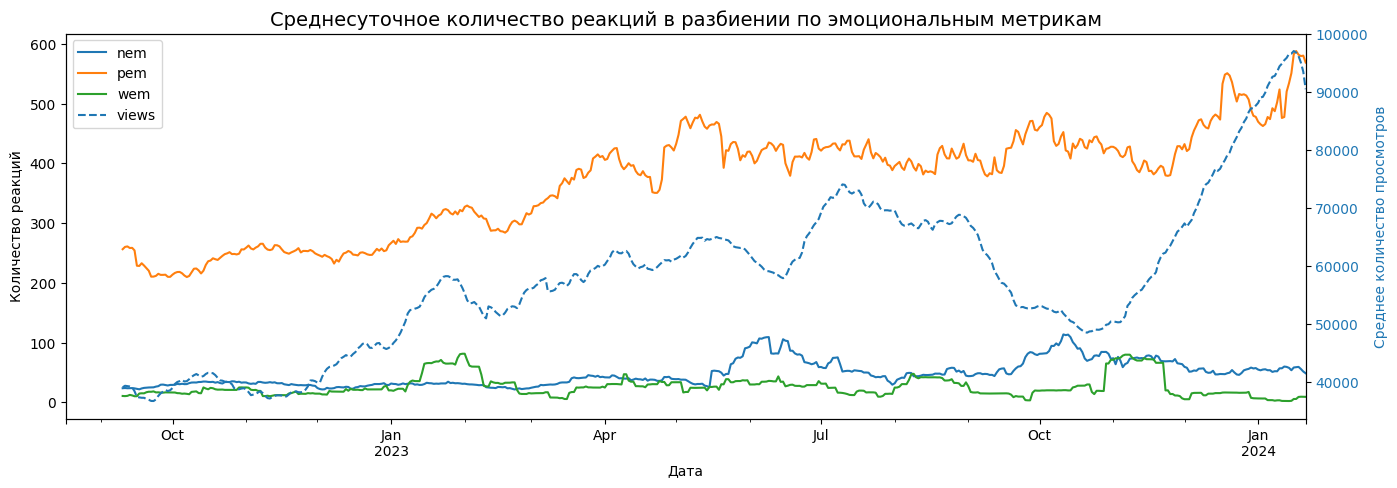

In [80]:
# Создаем объект "фигура" и оси
fig, ax1 = plt.subplots(figsize=(16, 5))

# Строим первую линию на левой оси
ax1.set_xlabel('Дата')
ax1.set_ylabel('Количество реакций')
df_posts.pivot_table(index='yyyy_mm_dd', values=['pem', 'nem', 'wem'], aggfunc='mean').rolling(25).mean().plot(ax=ax1, xlabel='Дата')
ax1.tick_params(axis='y')

# Создаем правую ось
ax2 = ax1.twinx()

# Строим вторую линию на правой оси с пунктирной линией
color = 'tab:blue'
ax2.set_ylabel('Среднее количество просмотров', color=color)
df_posts.pivot_table(index='yyyy_mm_dd', values=['views'], aggfunc='mean').rolling(25).mean().plot(ax=ax2, color=color, linestyle='--', legend=False)
ax2.tick_params(axis='y', labelcolor=color)

# Генерируем общую легенду
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Добавляем заголовок
plt.title('Среднесуточное количество реакций в разбиении по эмоциональным метрикам', fontsize=14)

# Отображаем график
plt.show()

Совершенно неожиданно обнаружилась чёткая взаимосвязь между повышением метрики негативных эмоций и падением просмотров публикаций пользователями. При этом "сочувствующе-печальные эмоции"(WEM), похоже, наоборот способствуют росту просмотров. Более низкая зависимость между проставлением положительных эмотиконов и динамикой просмотров, возможно, отчасти вызвана стимулирующими постановку таких эмоджи голосованиями, но это предположение нуждается в специальном исследовании.

#### Классификация типов и тем постов

Дифференцируем публикации по их типу и теме.

**Выделим 8 типов постов:**
- *Новостной* - о новостях в киноиндустрии;
- *Рекомендательный* - в котором собраны дайджесты и подборки;
- *Аналитический* - исследования и аналитика;
- *Вовлекающий* - различные типы активностей, повышающие активность подписчиков;
- *Промоционный* - продвигающий внешние ресурсы Кинопоиска;
- *Обзорный* - различные материалы о киноиндустрии;
- *Интервьерский* - репортажи, интервью, беседы
- *Иной* - для публикаций, которые не удастся дифференцировать


In [81]:
#создадим функцию для классификации типов постов
def classify_posts(text):
    if any(word in str(text) for word in ['новост', 'Новый фильм', 'кинопремьер', ' премьеру', 'Премьер','анонс', 'предстоящ', 'кинособыт', 'вручат', 'трейлер', 'вышли в Букмейте',
                                          'Новый постер', 'объявили сегодня', 'тизер', 'Фильм выйдет', 'вышла', 'Очень ждем', 'со съемок', 'вышло', 'церемонии', 'Любуемся', 'вручили',
                                          'скоро', 'возвращается', 'выходит', 'новые кадры', 'прокат', 'вышел', 'появится', 'выйдет', 'Этот голос узнаешь из тысячи', '😭😭😭',
                                          'Новая адаптация', 'стартовал', 'новая серия', 'попрощался',  'больше [не будет]', 'опубликов', 'уже близко']):
        return 'новостной'
    elif any(word in str(text) for word in ['дайдж', 'подборк', ' списк', 'путеводитель', 'список', 'Собрали', 'Выбрали', 'собранн', 'совет', 'лучшие фильмы', '[гайд]', 'выбрали',
                                            'выбрало', 'Выбираем', 'слушайте']):
        return 'рекомендательный'
    elif any(word in str(text) for word in ['анализ', 'тенденц', 'Разбираем', 'реценз', 'разбираем', '#коротыш', 'изучаем', 'Зельвенский', 'Изучаем', 'редакторам', 'рейтинг', 'бинго',
                                            'осмысл', '#КП100ВеликихФильмов']):
        return 'аналитический'
    elif any(word in str(text) for word in [' опрос', 'голосован', 'пишите', 'коммент', '👍', '👎', 'в комментариях', 'Жмякнуть голос', 'Давайте покажем', 'Ставь', 'Держимся', 'тесте'
                                           'даркона', '[клевом тесте]', 'С годом', 'Прощай, 2023', '#Дождались', 'Главный вопрос', 'Какие', 'у вас как', 'Сводим олдскулы…',
                                            'дерзкие ответочки', 'Ждете возвращения', '#Подслушано', 'Муд', 'делитесь', 'Два, три, Юра, приди!', 'Вы не готовы...', 'У нас тут']):
        return 'вовлекающий'
    elif any(word in str(text) for word in ['Фильм дня', 'квиз', 'Сериал недели', '#КиноПоПятницам', 'Сериал дня', 'Смотрите', 'Включаем', 'включаем', 'Фильм на вечер', 'смотрим',
                                            'посмотреть', 'спецэпизод', 'Мультфильм дня', 'Триггер. Фильм', 'пожаловать в канал', '[**Фильм**]', 'Дорама недели', 'уже на Кинопоиске']):
        return 'промоционный'
    elif any(word in str(text) for word in ['подробнее читайте', '#ДежурныйПоКинопоиску',  'читайте здесь', 'профайл ', 'профайле ', 'профайле]', 'профайл]', 'читайте [здесь]',
                                            'рассказываем', 'Рассказываем', 'нас — видео', '[Вспомнили]', 'смотрим в', 'Отвечаем', 'посмотрим', 'Отмечаем', 'мы писали', 'чтения!',
                                            '[гид]', 'Ганкин', 'вспоминаем', 'Вспоминаем','видеоэссе', 'Видеоэссе','читайте', 'Проливаем', 'видео', 'Делимся', 'топ-10', 'обзор',
                                            'рассказывают про', 'крутые статьи', '[вспомнили]', '[перечитать]', 'узнаете', 'Прочитали', 'писали', '[пишет]', 'снял короткометражку',
                                            ]):
        return 'обзорный'
    elif any(word in str(text) for word in ['поговорили с ', 'Поговорили с ', 'интервью ', 'интервью ', '[поговорил]', 'наш новый гость', 'Дежурный', 'Главный герой', '[расспросили]',
                                            'Актер рассказал']):
        return 'интервьюерский'

    else:
        return 'иной'

Создадим в датафрейме со сведениями о постах дополнительную метрику `post_type`:

In [82]:
#применяем функцию
df_posts['post_type'] = df_posts['text'].apply(classify_posts)

In [83]:
#проверяем созданный столбец на пропуски
df_posts['post_type'].isna().sum()

0

In [84]:
#Проверяем, какая часть осталась недифференцированной
print('Доля неспецифических постов равна', round(df_posts.query('post_type == "иной"')['post_type'].count()/df_posts['post_type'].count()*100), '%')

Доля неспецифических постов равна 25 %


В силу высокой специфичности публикаций в канале Кинопоиск, представляется неэффективным их дальнейшее разделение. Также на данном этапе не представляется целесообразным дальнейшее разделение постов на темы - ещё более мелкие подклассы типов постов, т.к. их преполагаемая корреляция с изменением числа подписчиков представляется несущественной.

#### Построение корреляционной матрицы Phik

Для финализации анализа показателей постов и их взаимосвязи с уровнем подписки, построим корреляционную матрицу phik, чтобы убедиться, что от нашего взгляда ничего не ускользнуло.\
Выбор матрицы phik обусловлен тем, что он позволяет позволяет выявить более сложные связи, чем просто линейная корреляция. Её преимуществом является способность обнаруживать нелинейные связи и взаимодействия между переменными, что позволяет выявить скрытые паттерны и зависимости между признаками.

Исключим из анализа заведомо непоказательные параметры: `все эмодзи, id, date, text`:

In [85]:
#создадим датасет для корреляции
df_posts_corr = df_posts[['views', 'forwarded', 'reactions_count', 'comments', 'type_attachment', 'yyyy_mm_dd', 'text_amount', 'text_difficulty',
                          'text_links', 'subscribers', 'changes', 'sum_actions', 'err', 'er', 'pem', 'nem', 'wem', 'post_type']]

In [86]:
#строим корреляционную матрицу phik:
data_corr = df_posts_corr.phik_matrix(interval_cols=['views', 'forwarded', 'reactions_count', 'comments', 'text_amount', 'text_difficulty', 'text_links', 'subscribers', 'changes', 'sum_actions', 'err', 'er', 'pem', 'nem', 'wem'])

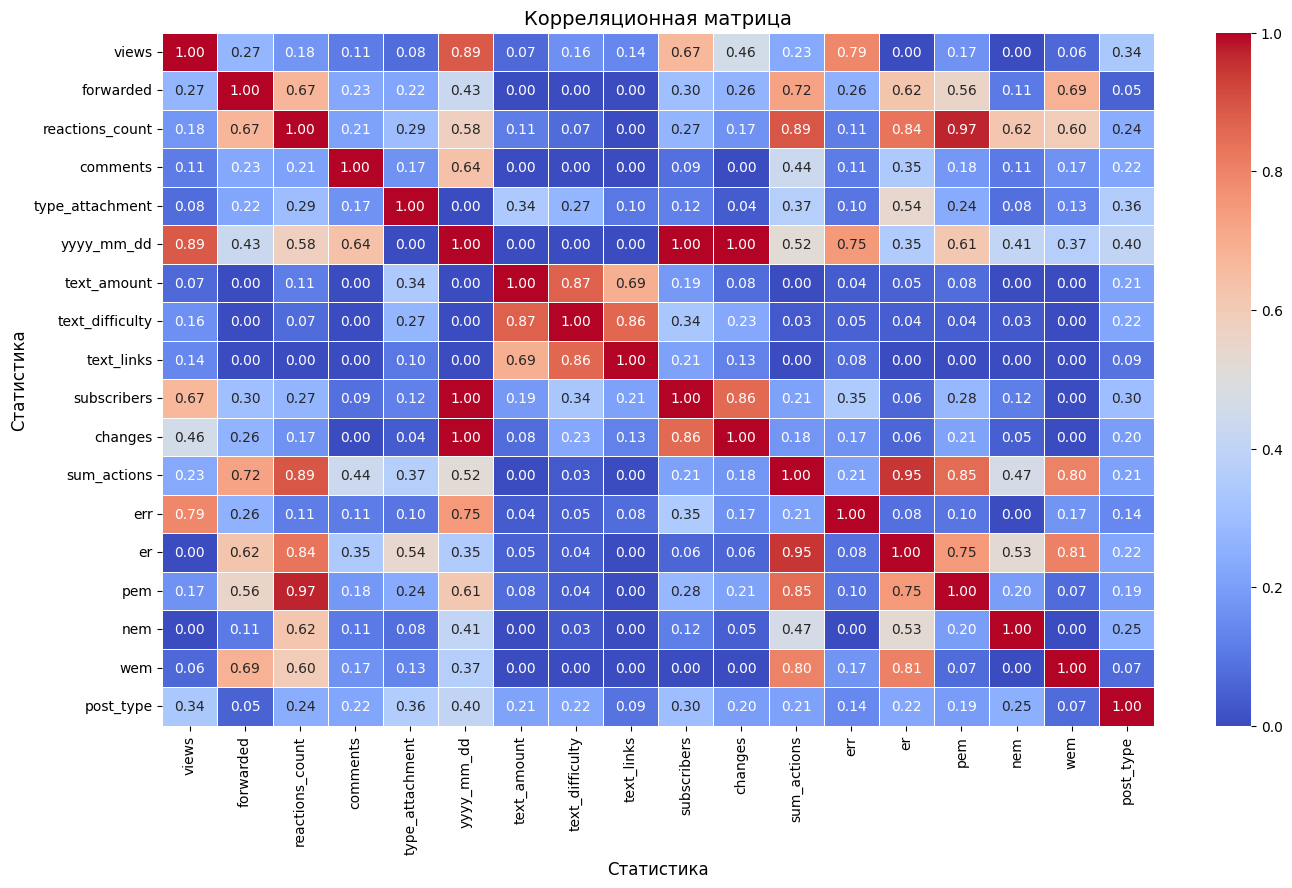

In [87]:
#формируем heatmap
plt.figure(figsize=(16, 9))
sns.heatmap(data=data_corr, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)

plt.title('Корреляционная матрица', fontsize=14)
plt.xlabel('Статистика', fontsize=12)
plt.ylabel('Статистика', fontsize=12)

plt.show()

Проанализируем матрицу, чтобы проверить, не ускользнуло ли что-то от нашего взгляда из предыдущего анализа.
Прежде всего обратим внимание на только что созданный параметр `post_type` (тип поста): он слабо коррелирует только с датой и типом вложения к посту - 0,4 и 0,36 соответвенно, что может говорить о том, что какой-то из классов локализуется преимущественно с одним типом вложений и в течение ограниченного периода времени. С остальными параметрами корреляция очень слабая, что убеждает нас в правильности решения отказаться от классификации постов на более мелкие классы - темы.
`Количество просмотров` ожидаемо сильно коррелирует с `количеством подписчиков` и `датой` -  в районе 0.8 и, примерное вдвое слабее с `суточным изменением уровня подписчиков` - 0.46.
Все `текстовые метрики` (сложность, объём) ожидаемо коррелируют между собой, так же как и все реакции подписчиков, что ожидаемо, так как они являются подмножествами друг друга. В целом следует признать, что корреляционная матрица нам никаких неожиданных открытий и материалов для размышления не принесла. Хотя, возможно, следовало взять данные за более узкий временной период для получения более яркой картины.

### Расчёт KPI

В качестве KPI обычно предлагается взять следующие стандартные метрики:
1. Прирост подписчиков канала в месяц;
2. Уровень вовлечённости по взаимодействиям ER,
3. Уровень вовлечённости по ERR

Основная проблема состоит в определении числовых критериев оценки сотрудников. Поэтому за основу предлагается взять благоприятные периоды развития канала и установить их уровень. Мы может отметить 2 таких периода: один до вирусной механики, второй - во время запуска и функционирования чат-бота.
Попробуем высчитать нормативы КPI на этой основе.\
За первый период возмём временной отрезок с 1 июня до 1 сентября, когда, согласно графика, был период умеренного роста канала:

In [88]:
#посчитаем рост канала в количестве подписчиков:

print('Среднее значение роста канала в месяц:',round(((np.ptp(df_subs_days[df_subs_days['date'].between('2023-06', '2023-09')]['subscribers'])
/df_subs_days.query('date == "2023-06-01"')['subscribers']*100)/3), 1).to_string(index=False), '%')

Среднее значение роста канала в месяц: 3.8 %


Таким образом, увеличение количества подписчиков на 4% в месяц в условиях "мирного времени" можно считать нормальным показателем. Посчитаем тот же компонент во время работы вирусного чат-бота, т.е. в период с 16 ноября по 31 декабря 2023 года:


In [89]:
print('Среднее значение роста канала в месяц при вирусной акселерации:',round(((np.ptp(df_subs_days[df_subs_days['date'].between('2023-11-16', '2024-01-16')]['subscribers'])
/df_subs_days.query('date == "2023-11-16"')['subscribers']*100)/2), 1).to_string(index=False), '%')

Среднее значение роста канала в месяц при вирусной акселерации: 35.2 %


При "вирусной акселерации" следует придерживаться значений почти в 10 раз больше.\
Что касается стандартных показателей ER и ERR, то, как мы убедились на предыдущих этапах исследования, их вряд и можно использовать в виде KPI, потому что они зачастую осуществляют разнонаправленное движение. При этом следует отметить, что в период максимального роста подписки обе метрики демонстрировали реверсивное движение.\
Единственнной метрикой, продемонстрировавшей отзывчивость на рост подписчиков, оказалась пересылка. Возможно использовать её усреднённое значение. Проверим это:

In [90]:
print('Среднее значение роста числа пересылок в месяц при вирусной акселерации:',round(((df_posts.pivot_table(index='yyyy_mm_dd', values=['forwarded'],
aggfunc='mean').rolling(25).mean().loc['2024-01-16'] - df_posts.pivot_table(index='yyyy_mm_dd', values=['forwarded'], aggfunc='mean').rolling(25).mean().loc['2023-11-16'])
/df_posts.pivot_table(index='yyyy_mm_dd', values=['forwarded'], aggfunc='mean').rolling(25).mean().loc['2023-11-16']/2*100),1).to_string(index=False), '%')

Среднее значение роста числа пересылок в месяц при вирусной акселерации: 35.4 %


Усреднённый рост средних пересылок практически совпадает с ростом подписчиков. Это значит, что во время действия вирусных технологий использование данной метрики вполне применимо.\
Кроме того, можно предположить, что каналу следует придерживаться того же соотношения публикаций с видео/фото и ссылочных вложений, которое было в период максимального роста. Рассчитаем его:

In [91]:
print('Среднее соотношение количества медиаконтента по сравнению со ссылочной при вирусной акселерации:', round(((df_posts.query('type_attachment == "видео" & "2023-11-16" < yyyy_mm_dd < "2024-01-16"')['views'].sum() +\
df_posts.query('type_attachment == "фото" & "2023-11-16" < yyyy_mm_dd < "2024-01-16"')['views'].sum())/\
df_posts.query('type_attachment == "ссылка" & "2023-11-16" < yyyy_mm_dd < "2024-01-16"')['views'].sum()*100)),'%')

Среднее соотношение количества медиаконтента по сравнению со ссылочной при вирусной акселерации: 139 %


Т.е. медиаконтент (фото и видео) должны минимум в 1,4 раза превосходить ссылки на другие ресурсы, что тоже может являться KPI.\
Ну и, наконец, нами было обнаружено, что эмоджи-метрика NEP (негативные эмоции) также выглядит связанной с падением просмотров и даже числа подписчиков. Вероятно, уровень выплёскиваемой пользователями в канал негативной эмоциональной энергии также должен подлежать учёту и управлению.

### Семантический анализ комментариев

Перед нами поставлена задача сделать семантический анализ комментариев с целью понять, какие посты побуждают людей к действию.\
Данные предыдущего анализа вполне убедили нас, что комментаторов на канале Кинопоиск, кажется неспособно подвигнуть к действию ничего - число комментариев крайне мало и с увеличением подписки их среднесуточное количество не только не растёт, но даже уменьшается.  В связи с этим, вероятно, не имеет никакого смысла анализировать весь массив комментариев. Гораздо более релевантным будет проанализировать комментарии к постам, вызвавшим максимальный отклик телеграмных "рыцарей трекпоинта и тачпада".\
Приступим к поиску таких постов, с целью чего сделаем гистограмму:

In [92]:
df_comments.pivot_table(index='id', values='text_comment', aggfunc='count')

text_comment
id                 
28701             9
28711            15
28712            37
28713            22
28714            16
...             ...
37059            12
37060            26
37064            27
37066            55
37068            30

[3931 rows x 1 columns]

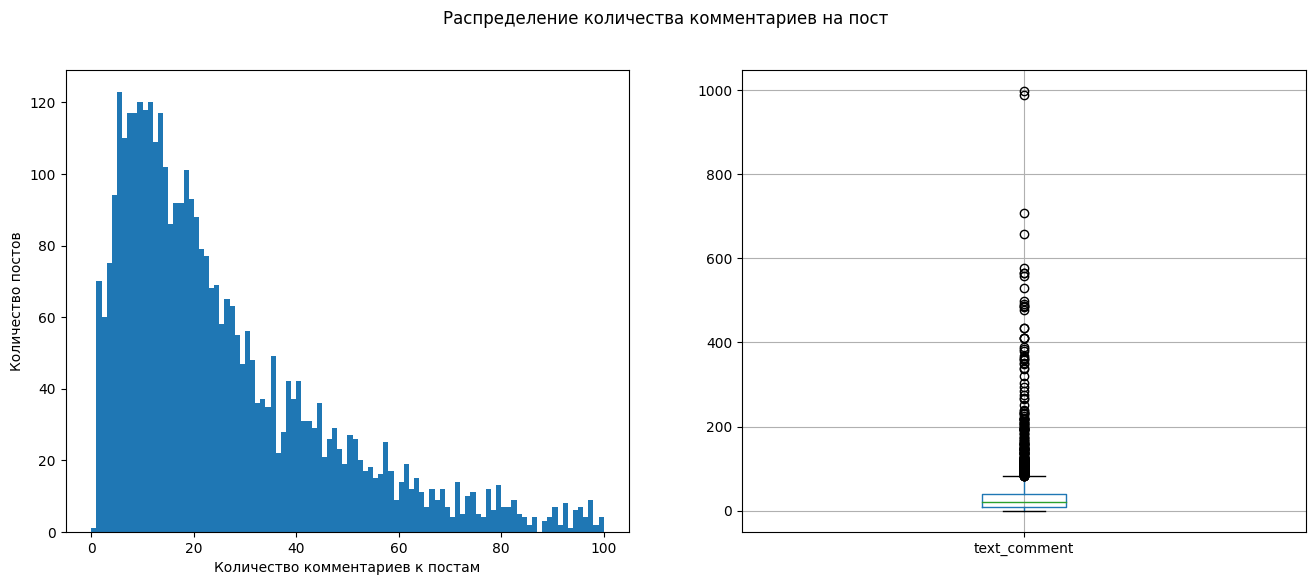

In [93]:
#гистограмма частоты встречаемости постов и боксплот
#df_comments.pivot_table(index='id', values='text_comment', aggfunc='count').plot(kind='hist', bins=100, range=(0,100));
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Первый график - гистограмма
df_comments.pivot_table(index='id', values='text_comment', aggfunc='count').plot(kind='hist', bins=100, range=(0, 100), ax=ax1, legend=False)

# Добавление подписей к осям
ax1.set_xlabel('Количество комментариев к постам')  # По шкале x
ax1.set_ylabel('Количество постов')  # По шкале y

# Второй график - боксплот
df_comments.pivot_table(index='id', values='text_comment', aggfunc='count').boxplot(ax=ax2)

fig.suptitle('Распределение количества комментариев на пост')
plt.show()

Мы видим, что бывает и по 1000 постов под некоторыми публикациями, но большая часть всё же сосредоточена до 100, именно поэтому мы выбрали такой диапазон экспонирования.\
Выясним, какие именно публикации набрали около 1000 комментариев:

In [94]:
df_comments.pivot_table(index='id', values='text_comment', aggfunc='count').query('text_comment >= 900')

text_comment
id                 
32763           998
33211           989

Посмотрим, о чём эти посты:

In [95]:
df_posts[df_posts['id'].isin([32698, 32763, 33211])][['id', 'text']]

id                                               text
1603  33211                     Ждем ваши ответы в комментах 👀
1802  32763                     Ждем ваши ответы в комментах 👀
1838  32698  Флешмоб! \n\nВыложите постер фильма, который в...

Очевидно, что такое количество комментариев спровоцировано прямым призывом Кинопоиска к обсуждению, поэтому исключим их из дальнейшего анализа, поскольку в даннном случае причина, побудившая пользователей написать комментарий, ясна.\
На всякий случай, проанализируем ещё несколько постов из области пиковых значений:

In [96]:
df_comments.pivot_table(index='id', values='text_comment', aggfunc='count').query('550 <text_comment < 900')

text_comment
id                 
31859           707
31932           657
32487           558
32573           564
33104           566
33290           576

Также посмотрим их содержание:

In [97]:
top_posts = df_comments.pivot_table(index='id', values='text_comment', aggfunc='count').query('400 <text_comment < 900').index.values
df_posts[df_posts['id'].isin(top_posts)][['id', 'text']]

id                                               text
495   35900  Друзья, у нас конкурс!\n\nДано: 100 великих фи...
1081  34477  Вампиры, трепещите!\n\nВ ожидании финала второ...
1218  34138                     Ждем ваши ответы в комментах 💎
1302  33952  Конкурс для фанатов видеоэссе[!](https://i.img...
1355  33817                          Ждем ответы в комментах 📺
1435  33607  Ждем ответы в комментах 🕹\n\nP.S. Кстати, про ...
1572  33290  Пятничная флудилка? Почему нет!\n\nСегодня всп...
1649  33104                     Ждем ваши ответы в комментах 🐳
1686  33031                      Ждем ваши ответы в комментах!
1761  32848                          Ждем ответы в комментах 📚
1896  32573                  Ждем ваши ответы в комментариях 🙃
1945  32487                  Ждем ваши ответы в комментариях 🎞
1997  32382                                       Ваш выбор? 📺
2050  32293                    Ждем ваши идеи в комментариях 🎸
2216  31985  **Премьера «Короля и Шута» через четыре часа! ...
2242  31932                       Ждем ответы в комментариях 💿
2277  31859                       Ждем ответы в комментариях 🙌
2921  30684  Сегодня президент Владимир Путин подписал зако...

Становится совершенно очевидным, что топовое количество постов на канале в первую очередь вызвано призывами Кинопоиска оставлять свои сообщения в комментариях под тем или иным предлогом.\
Узнаем количество таких постов:

In [98]:
#находим количество всех постов со словосочетанием "в комментариях"
print('Количество постов, призывающих оставлять комментарии:', len(df_posts[df_posts['text'].astype(str).str.contains('в комментариях|в комментах|в комменты', case=False, na=False)]['id'].values))

Количество постов, призывающих оставлять комментарии: 146


Выделим из выборки все посты, в которых встречается словосочетание "в комментариях" и сравним картину:

In [99]:
#находим id всех постов со словосочетанием "в комментариях"
comment_inducing_posts = df_posts[df_posts['text'].astype(str).str.contains('в комментариях|в комментах|в комменты', case=False, na=False)]['id'].values

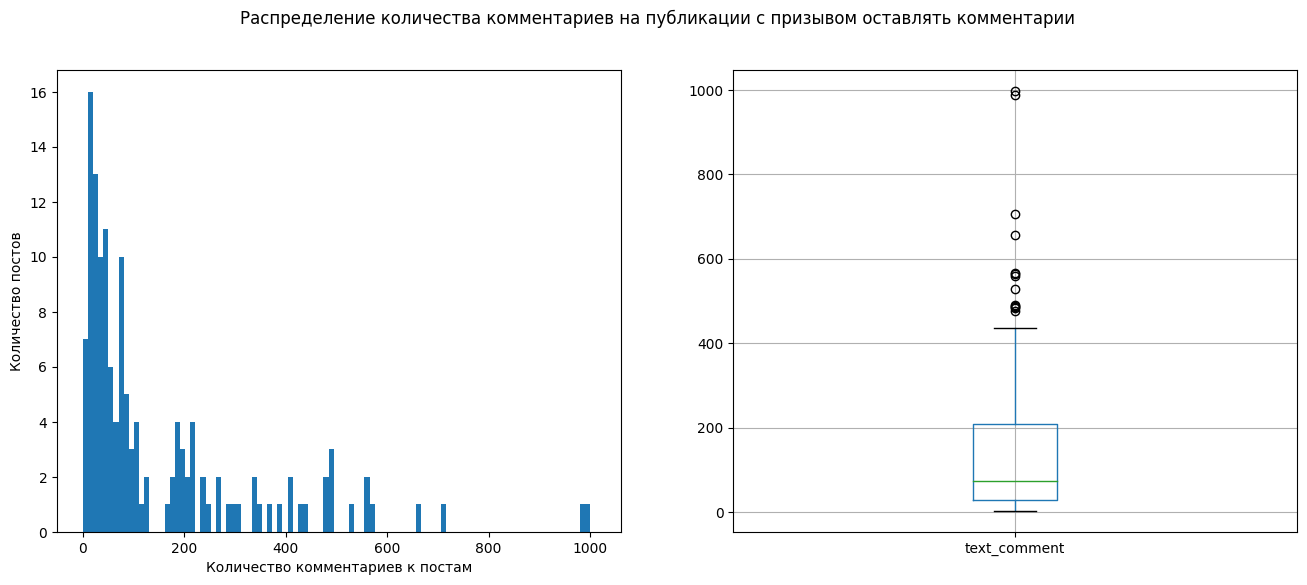

In [100]:
#гистограмма частоты встречаемости постов и боксплот
#df_comments.pivot_table(index='id', values='text_comment', aggfunc='count').plot(kind='hist', bins=100, range=(0,100));
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Первый график - гистограмма
df_comments.query('id in @comment_inducing_posts').pivot_table(index='id', values='text_comment', aggfunc='count').plot(kind='hist', bins=100, range=(0, 1010), ax=ax1, legend=False)

# Добавление подписей к осям
ax1.set_xlabel('Количество комментариев к постам')  # По шкале x
ax1.set_ylabel('Количество постов')  # По шкале y

# Второй график - боксплот
df_comments.query('id in @comment_inducing_posts').pivot_table(index='id', values='text_comment', aggfunc='count').boxplot(ax=ax2)

fig.suptitle('Распределение количества комментариев на публикации с призывом оставлять комментарии')
plt.show()

Из гистограммы мы видим, что значительное количество, содержащих призывы к комментированию, тем не меннее, были фактически проигнорированы подписчиками. Посмотрим "под лупой" на самые проигнорированные посты:

In [101]:
bottom_posts = df_comments.query('id in @comment_inducing_posts').pivot_table(index='id', values='text_comment', aggfunc='count').query('text_comment < 10').index.values
df_posts[df_posts['id'].isin(bottom_posts)][['id', 'text']].values

array([[36628,
        'Вы ждали, мы ждали — и вот, ваши **персональные книжные итоги года** уже можно посмотреть в приложении Букмейта. Ура? Ура!\n\nМы очень постарались, починили достижения и учли всё, что вы прочитали, прослушали или пролистали в 2023 году. Заходите и смотрите свою личную статистику: сколько часов вы провели за книгами, какие жанры предпочитали и кто ваш любимый автор. \n\nИ — самое главное — какой вы книжный покемон! Мы проанализировали ваши читательские паттерны и назначили всем персонажа. \n\nТак что кликайте [сюда](https://4276573.redirect.appmetrica.yandex.com/annual_stories_2023?open=true&appmetrica_tracking_id=460905248232375924&campaign_name=tg) или заходите сразу в приложение. Если итогов нет, нужно обновиться.\n\nДелитесь в комментариях, кто вам выпал 🔥\n\n\n😎 И подписывайтесь на [**«Букмейт»**](https://t.me/+w8unikBwg9E4MTc6)'],
       [36283,
        'Адам Сэндлер — ящерица, продолжение «Фарго», новый сериал Нэйтана Филдера и Бенни Сэфди, а также испанск

Все выделенные публикации имеют призывы к комментированию, однако, фразы, использованные для стимулирования подписчиков построены по другому: все "топовые посты" содержат призыв в сочетании со словом "ждём", в то время как в "низовых постах" используется лексика: "делитесь, выбирайте, пишите", т.е. призывы к подписчикам взаимодействовать друг с другом, а не с каналом. Условно назовём их "призывные" и "подталкивающие".\
Попробуем проверить, насколько различаются эти два способа стимулирования количества комментариев. Посмотрим разницу между постами со словами "ждём" и иными сочетаниями:

In [102]:
#находим id постов со словом ждём
pattern = r'жд[её]м.*(\bв\s+комментариях\b|\bв\s+комментах\b)'
comment_inducing_wait_posts = df_posts[df_posts['text'].astype(str).str.contains(pattern, case=False, na=False)]['id'].values

In [103]:
#отделяем выделенные категории "побуждающих" постов друг от друга
comment_inducing_other_posts = list(set(comment_inducing_posts) - set(comment_inducing_wait_posts))

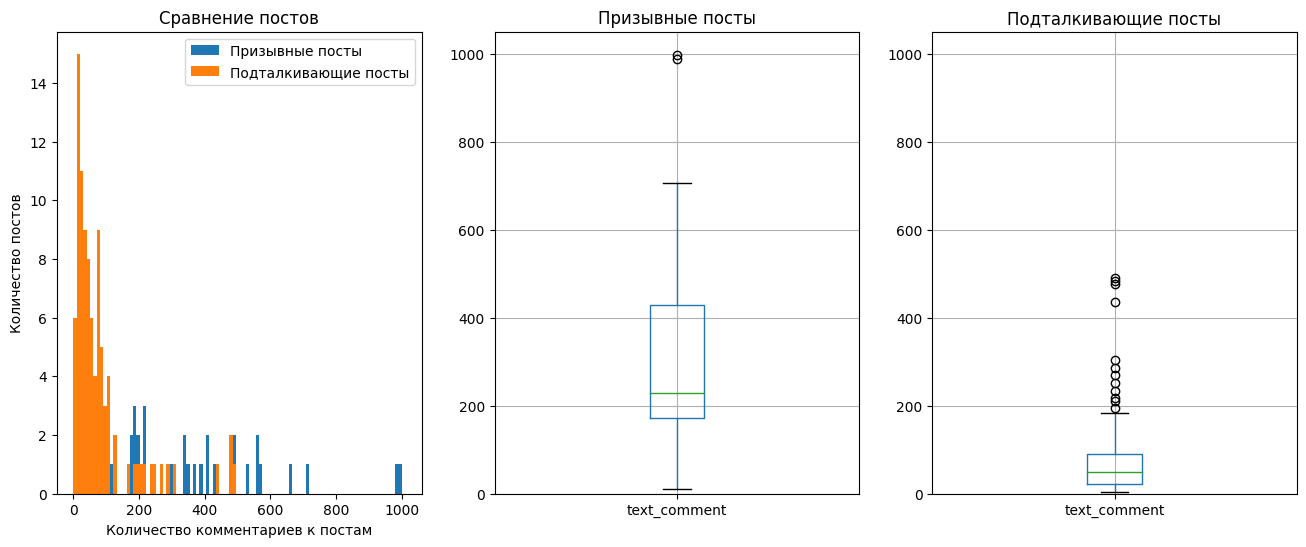

In [104]:
#гистограмма частоты встречаемости постов и боксплот
#df_comments.pivot_table(index='id', values='text_comment', aggfunc='count').plot(kind='hist', bins=100, range=(0,100));
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

# Первый график - гистограмма
df_comments.query('id in @comment_inducing_wait_posts').pivot_table(index='id', values='text_comment', aggfunc='count').plot(kind='hist', bins=100, range=(0, 1010), ax=ax1, legend=False)
df_comments.query('id in @comment_inducing_other_posts').pivot_table(index='id', values='text_comment', aggfunc='count').plot(kind='hist', bins=100, range=(0, 1010), ax=ax1, legend=False)
ax1.set_title('Сравнение постов')
ax1.legend(["Призывные посты", "Подталкивающие посты"])

# Добавление подписей к осям
ax1.set_xlabel('Количество комментариев к постам')  # По шкале x
ax1.set_ylabel('Количество постов')  # По шкале y

# Второй график - боксплот
df_comments.query('id in @comment_inducing_wait_posts').pivot_table(index='id', values='text_comment', aggfunc='count').boxplot(ax=ax2)
ax2.set_ylim(0, 1050)
ax2.set_title('Призывные посты')

# Третий график - боксплот
df_comments.query('id in @comment_inducing_other_posts').pivot_table(index='id', values='text_comment', aggfunc='count').boxplot(ax=ax3)
ax3.set_ylim(0, 1050)
ax3.set_title('Подталкивающие посты')
plt.show()

На представленных графиках мы наглядно видим, что "призывные публикации" где канал выступает в качестве ожидающей стороны имеют совсем иное распределение, нежели "подталкивающие". Медианное значение "призывных" постов выше четвёртого квартиля "подталкивающих". Т.е. 50% первых приносит большее количество комментариев, чем 90% вторых.\
Возможно, следует дополнительно провести качественный анализ отличия первой и второй групп, но то, что они есть - налицо!

Поскольку подписчики делают комментарии так же и под постами, не содержащими в себе призывов это делать, попробуем найти ответ на вопрос, что ими движет в этом случае.\
Убираем из выборки все комментарии к категории уже рассмотренных нами постов и продолжим наше исследование:


In [105]:
#удаляем из датасета с комментариями все строки к стимулирующим комментарии постам
df_comments = df_comments[~df_comments['id'].isin(comment_inducing_posts)]

Проверим, как изменилось распределение, после удаления части постов:

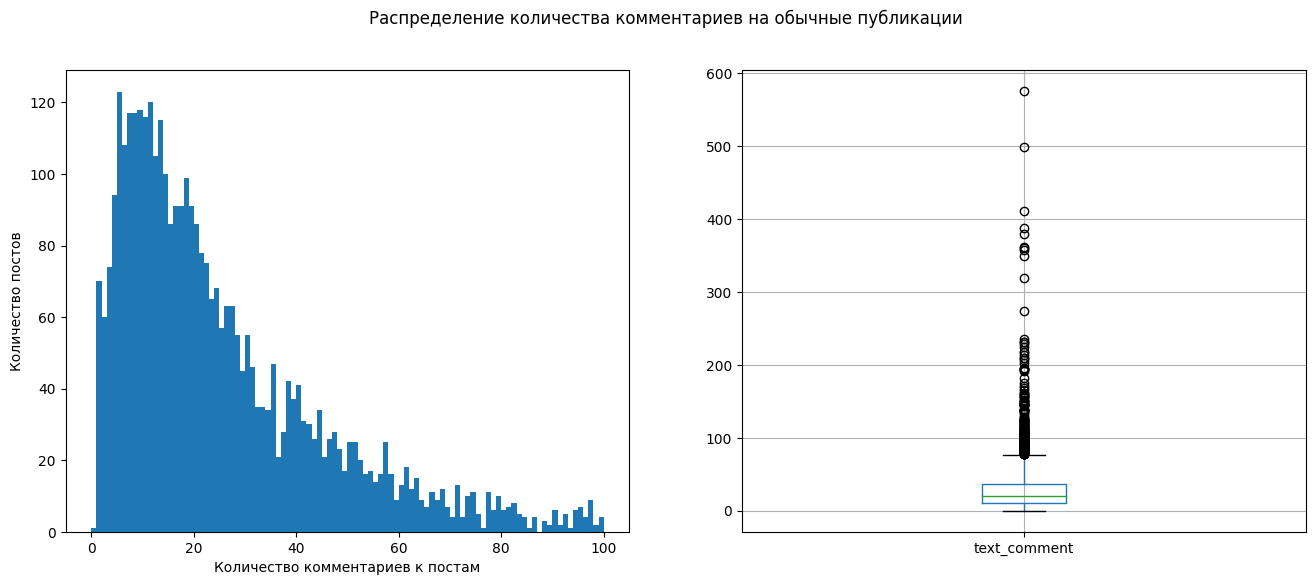

In [106]:
#гистограмма частоты встречаемости постов и боксплот
#df_comments.pivot_table(index='id', values='text_comment', aggfunc='count').plot(kind='hist', bins=100, range=(0,100));
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Первый график - гистограмма
df_comments.pivot_table(index='id', values='text_comment', aggfunc='count').plot(kind='hist', bins=100, range=(0, 100), ax=ax1, legend=False)

# Добавление подписей к осям
ax1.set_xlabel('Количество комментариев к постам')  # По шкале x
ax1.set_ylabel('Количество постов')  # По шкале y

# Второй график - боксплот
df_comments.pivot_table(index='id', values='text_comment', aggfunc='count').boxplot(ax=ax2)

fig.suptitle('Распределение количества комментариев на обычные публикации')
plt.show()

Картина изменилась, что свидетельствует об успешной операции удаления "лишних" строк. На всякий случай, просматриваем, "топ" оставшихся постов:

In [107]:
#находим посты с количеством комментариев более 250
df_comments.pivot_table(index='id', values='text_comment', aggfunc='count').query('250 < text_comment').sort_values(by='text_comment', ascending=False).T

id            33290  32382  30684  32709  31397  31802  35782  34917  31189  \
text_comment    576    499    411    388    380    362    360    358    349   

id            28997  35549  
text_comment    319    274

In [108]:
#просматриваем посты в порядке убывания
top_posts_remained = df_comments.pivot_table(index='id', values='text_comment', aggfunc='count').query('250 < text_comment').sort_values(by='text_comment', ascending=False).index.tolist()

for post_id in top_posts_remained:
    text = df_posts[df_posts['id'] == post_id][['id', 'text']].iloc[0]
    wrapped_text = textwrap.wrap(text['text'], width=180)
    first_line = True
    for line in wrapped_text:
        if first_line:
            print(text['id'], line)
        else:
            print(line)
        first_line = False
    print(' ')

33290 Пятничная флудилка? Почему нет!  Сегодня вспоминаем фильмы, в которых злодеи вызывают больше симпатии и сочувствия, чем главные герои.   У вас есть такие?
 
32382 Ваш выбор? 📺
 
30684 Сегодня президент Владимир Путин подписал закон о запрете «пропаганды ЛГБТ».   Кинопоиск
[опросил](https://www.kinopoisk.ru/media/article/4007132/?utm_source=telegram&utm_medium=social) издателей, книжные сервисы и экспертов о том, как закон повлияет на их
деятельность.
 
32709 Покажите сцену из фильма, во время которой вы всегда плачете.   У нас это [«Зеленая миля» ](https://hd.kinopoisk.ru/film/42e511a460839b298d96effd8de60c68?from_block=kp-button-
online&watch=)с Томом Хэнксом 😢
 
31397 Ура, ура, ура! Объявлены номинанты на 95-ю премию «Оскар».   Скорее смотрите полный список номинантов по [этой
ссылке](https://www.kinopoisk.ru/media/news/4007350/?utm_source=telegram&utm_medium=social).  P.S. Материал дополняется…
 
31802 Друзья, а давайте сыграем в игру🤘  Правила проще некуда: мы пишем название 

Мы видим, что по-прежнему среди "топовых постов" значительное количество занимают "подталкивающие" публикации, провоцирующие на написание комментария, просто в несколько иной форме, чем было выявлено ранее. К используемой лексике следует добавить "выложите, покажите, вспоминаем, делимся, давайте сыграем в игру, делитесь и т.д." Вместе с тем, мы видим реакции на топовые события в мире киноиндустрии: Оскар, финалы сериалов, Нобелевская премия по литературе, вероятно, актуальная для аудитории Кинопоиска информация о законах, регулирующих ЛГБТ пропаганду.\
Для того, чтобы попробовать выявить мотивацию пользователей оставлять комментарии на рядовой материал, отбросим выбросы и возьмём срез комментариев на посты между третьим и четвёртым квартилем. Определим их границы:

In [109]:
#определяем границы срезов:
data = df_comments.pivot_table(index='id', values='text_comment', aggfunc='count')['text_comment']

# Вычисление квантилей
quantiles = np.percentile(data, [25, 50, 75])
print("Квантили:", quantiles)

# Вычисление межквартильного размаха
IQR = quantiles[2] - quantiles[0]
print("Межквартильный размах:", IQR)

# Вычисление границ "усов"
lower_whisker = quantiles[0] - 1.5 * IQR
upper_whisker = quantiles[2] + 1.5 * IQR
print("Нижний 'ус':", lower_whisker)
print("Верхний 'ус':", upper_whisker)

Квантили: [10. 20. 37.]
Межквартильный размах: 27.0
Нижний 'ус': -30.5
Верхний 'ус': 77.5


Возьмём посты, которые находятся в верхних границах распределения и при этом не являются выбросами, т.е. третьего квантиля до верхнего уса: 38 и 80 постов на пост, соотвественно. Посмотрим, сколько постов и комментариев имеется в этом диапазоне:

In [110]:
#считаем количество постов
df_comments.pivot_table(index='id', values='text_comment', aggfunc='count').query('38 <= text_comment <= 50').count()[0]

381

In [111]:
#считаем количество комментариев
df_comments.pivot_table(index='id', values='text_comment', aggfunc='count').query('38 <= text_comment <= 50').sum()[0]

16468

Мы имеем 381 пост к которым дано 16468 комментариев. Статистика должна быть более чем достаточной.\
Приступаем к подготовке данных:

In [112]:
#создаём списов id постов -"миллионников"
comments_id = df_comments.pivot_table(index='id', values='text_comment', aggfunc='count').query('38 <= text_comment <= 50').index.tolist()

#создаём аналитический дата-сет
#преобразуем данные

df_comments['text_comment'] = df_comments['text_comment'].astype(str)

#фильтруем таблицу

df_semantics = df_comments[df_comments['id'].isin(comments_id)]

#группируем с объединением строк, объединяя все комментарии к каждому посту в один текст

df_semantics = df_comments.groupby('id')['text_comment'].apply(' '.join).reset_index()

In [113]:
#просматриваем датасет для семантического анализа
df_semantics.head(5)

id                                       text_comment
0  28701  а четвертый сезон Документалистики сегодня не ...
1  28711  Хотя говорить о ней не особо можно так-то. Чек...
2  28712  Смотрим ровно до Диснея, дальше не надо + Изго...
3  28713  Пока что ожидаемо нудная хрень Дорогая пустышк...
4  28714  Страшненькая т а в комментариях на Ютубе к рол...

Датасет создан корректно. Создаём необходимые функции для обработки данных:

In [114]:
#функция для подготовки текста
def preprocess_text(text):
    # Удаляем пунктуацию
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Преобразуем в нижний регистр
    text = text.lower()
    return text

In [115]:
#функция для удаления слов, которые не несут смысловой нагрузки
'''
Принимает на вход текст и список стоп-слов. Удаляет те, которые присутствуют в списке стоп-слов. Объединяет оставшиеся слова в строку и возвращает ее.
'''
def remove_stopwords(cell):
    blob = TextBlob(cell)
    words = blob.words
    stop_words_list = stopwords.words('russian')  # Инициализация списка стоп-слов

    my_stop_words = ['а', 'я', '«', '»', 'и', 'в', '3', '2', '—', '1', 'с', '4', '5', 'у', '•', '–', 'ну', 'не', 'd0', 'да', 'но', 'd1', 'на', 'вы',
    'он', '10', 'кп', 'of', 'тв', 'зв', 'это', 'nan', 'ещё', 'как', 'всё', 'the', 'гая', 'нет', 'про', 'вот', 'уик', 'мне', 'если', 'пока', 'хотя', 'либо', 'тебе']
    stop_words_list += my_stop_words

    new_words = [word for word in words if word not in stop_words_list]
    return ' '.join(new_words)

In [116]:
#преобразуем слова в их начальную форму (лемму)
def lemmatize_russian_text(text):

    morph = pymorphy2.MorphAnalyzer()
    lemmatized_words = [morph.parse(word)[0].normal_form for word in text.split()]

    return ' '.join(lemmatized_words)

In [117]:
#функция для вывода пяти наиболее часто встречающихся слов
'''
принимает на вход ячейку из таблицы (в виде строки) и возвращает словарь, где ключами являются первые пять наиболее часто встречающихся слов, а значениями - их частота.
'''
from textblob import TextBlob

def extract_keywords(cell):
    blob = TextBlob(cell)
    words = blob.words
    counts = {}

    for word in words:
        counts[word.lower()] = counts.get(word.lower(), 0) + 1

    return dict(sorted(counts.items(), key=lambda item: item[1], reverse=True)[:5])


In [118]:
#функция для тегирования слов в соответствии с частями речи
def get_pos(cell):
    morph = pymorphy2.MorphAnalyzer()
    analyzed = morph.parse(cell)
    pos = analyzed[0].tag.POS
    return pos

In [119]:
#готовим текст
df_semantics['textblob'] = df_semantics['text_comment'].apply(preprocess_text)

In [120]:
#проверяем результат
df_semantics['textblob'][:5]

0    а четвертый сезон документалистики сегодня не ...
1    хотя говорить о ней не особо можно такто чекаг...
2    смотрим ровно до диснея дальше не надо  изгой ...
3    пока что ожидаемо нудная хрень дорогая пустышк...
4    страшненькая т а в комментариях на ютубе к рол...
Name: textblob, dtype: object

In [121]:
# Создаём список объектов TextBlob
#готовим текст, удаляем слова, которые не несут смысловой нагрузки
df_semantics['textblob'] = df_semantics['textblob'].apply(remove_stopwords)

In [122]:
#проверяем результат
df_semantics['textblob'][:5]

0    четвертый сезон документалистики сегодня анонс...
1    говорить особо такто чекаго смотрели капельник...
2    смотрим ровно диснея дальше изгой первый сезон...
3    ожидаемо нудная хрень дорогая пустышка мда пер...
4    страшненькая т комментариях ютубе роликам учас...
Name: textblob, dtype: object

In [123]:
#лемантизируем текст
#время выполнения процесса в Сolab - 10 минут
df_semantics['textblob'] = df_semantics['textblob'].apply(lemmatize_russian_text)

In [124]:
#проверяем результат
df_semantics['textblob'][:5]

0    четвёртый сезон документалистика сегодня анонс...
1    говорить особо такто чекаго смотреть капельник...
2    смотреть ровно дисней далёкий изгой первый сез...
3    ожидать нудный хрень дорогой пустышка мда пере...
4    страшненький так комментарий ютуба ролик участ...
Name: textblob, dtype: object

In [125]:
# создаём списки наиболее часто встречающихся слов
df_semantics['textblob'] = df_semantics['textblob'].apply(extract_keywords)

In [126]:
#проверяем результат
df_semantics['textblob'][:5]

0    {'сезон': 3, 'сериал': 3, 'ждать': 3, 'первый'...
1    {'смотреть': 3, 'наркотик': 3, 'сериал': 3, 'х...
2    {'смотреть': 9, 'фильм': 6, 'просто': 5, 'вооб...
3    {'экватор': 5, 'перевалить': 4, 'серия': 4, 'п...
4    {'красота': 3, 'сохнуть': 2, 'хотеть': 2, 'ирл...
Name: textblob, dtype: object

In [127]:
#создаём колонку с настроением текста
df_semantics['sentiment'] = df_semantics['text_comment'].apply(lambda tweet: TextBlob(tweet).sentiment)

In [128]:
#проверяем результат
df_semantics[['sentiment']][:5]

sentiment
0    (0.0, 0.0)
1  (-0.75, 1.0)
2    (0.0, 0.0)
3  (0.625, 1.0)
4    (0.0, 0.0)

Создаём новый датасет с ключевыми словами:

In [129]:
#преобразуем столбцец словарей в список словарей
words_dict_list = df_semantics['textblob'].tolist()

# Создаем словарь, где ключами будут слова, а значениями - их частота
common_words_dict = {}

# Проходим по каждому словарю в списке
for words_dict in words_dict_list:
    # Проходим по каждому слову в словаре
    for word, count in words_dict.items():
        # Если слово уже есть в словаре общих слов
        if word in common_words_dict:
            # Увеличиваем его частоту на текущую частоту
            common_words_dict[word] += count
        # Если слово еще не было в словаре общих слов
        else:
            # Добавляем его в словарь с текущей частотой
            common_words_dict[word] = count

# Создаем новый DataFrame с общими словами и их частотой
common_words_df = pd.DataFrame(list(common_words_dict.items()), columns=['word', 'qvt']).sort_values(by='qvt', ascending=False).reset_index(drop=True)

In [130]:
#оставляем в датасете 200 первых слов
common_words_df = common_words_df.head(200)

In [131]:
#создаём столбец с тэгами частей речи
common_words_df['tags'] = common_words_df['word'].apply(get_pos)

Все функции отработали штатно и сейчас мы имеем датасет с 200-ми наиболее часто встречающимися словами в комментариях. Посмотрим, как представлены в нем различные части речи:

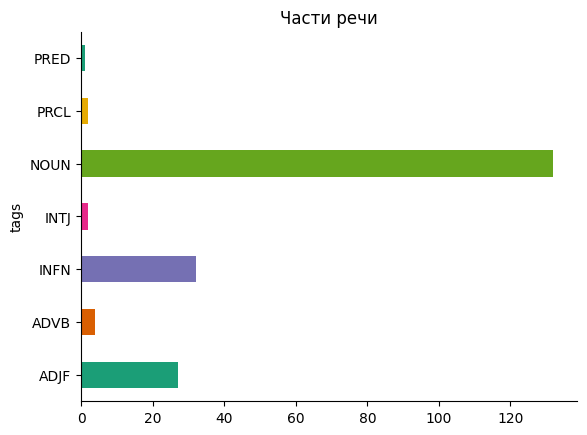

In [132]:
#строим столбчатую диаграмму с частями речи

common_words_df.groupby('tags').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title('Части речи')
plt.show()

Выведем первые 30 общих слов, и, затем, отдельно, существительные, глаголы и прилагательные, а также другие части речи:

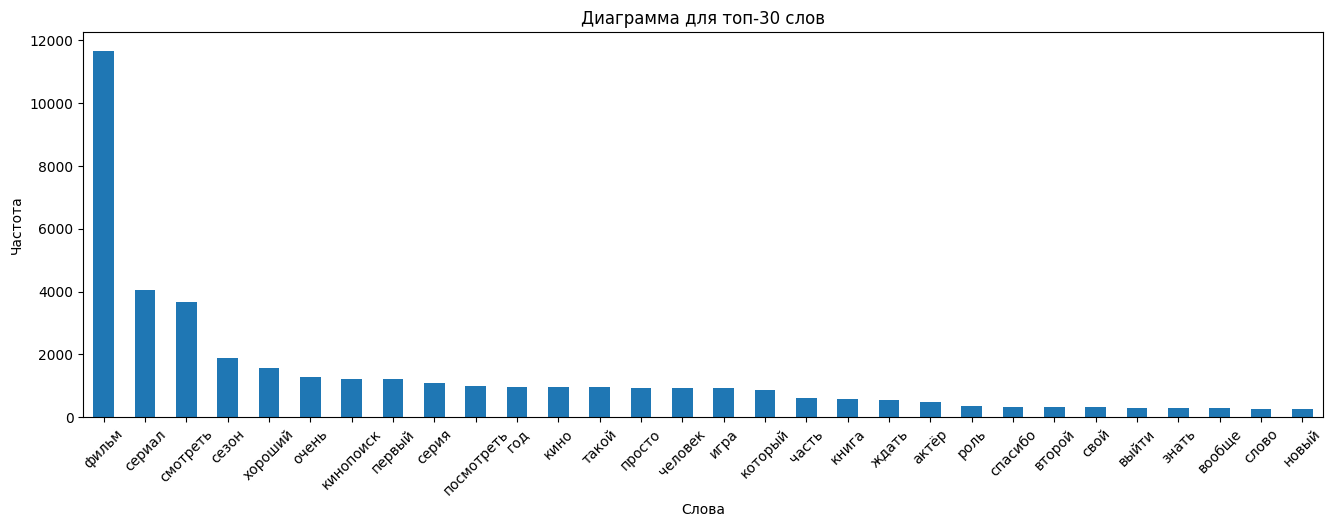

In [133]:
common_words_df.head(30).plot(kind='bar', x='word', y='qvt', rot=45, figsize=(16,5), legend=False, xlabel='Слова', ylabel='Частота', title='Диаграмма для топ-30 слов');

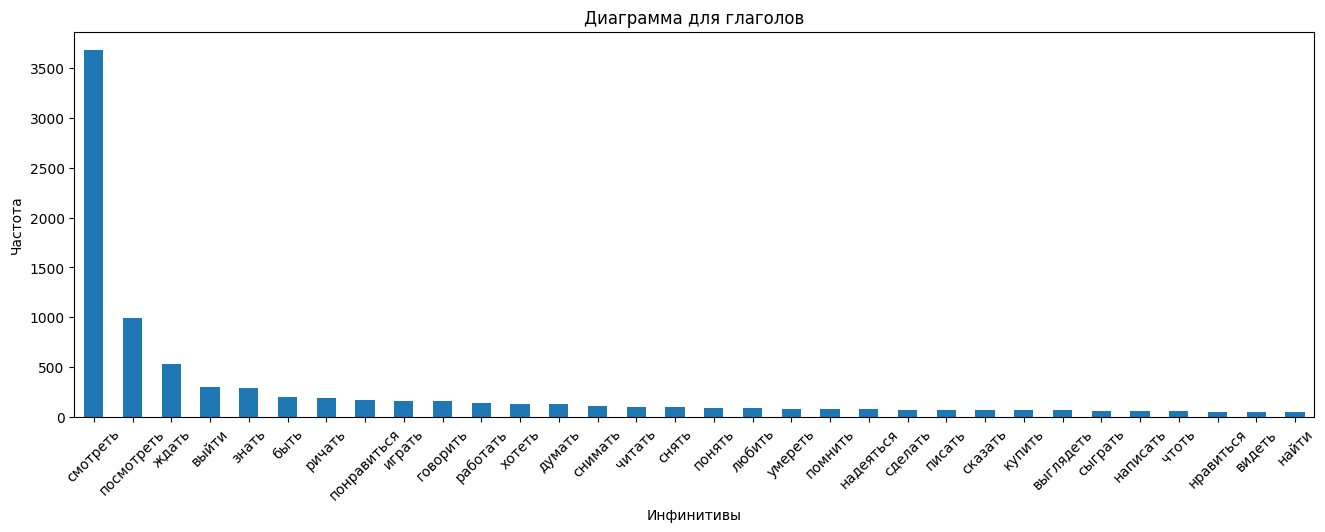

In [134]:
common_words_df.query('tags == "INFN"').plot(kind='bar', x='word', y='qvt', rot=45, figsize=(16,5), legend=False, xlabel='Инфинитивы', ylabel='Частота', title='Диаграмма для глаголов');

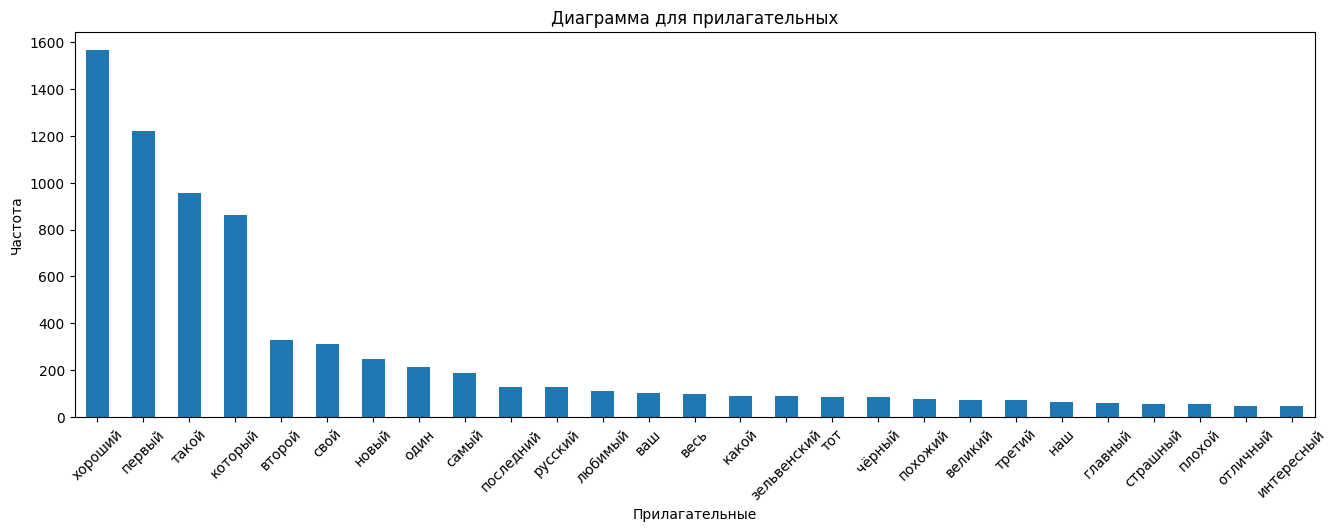

In [135]:
common_words_df.query('tags == "ADJF"').plot(kind='bar', x='word', y='qvt', rot=45, figsize=(16,5), legend=False, xlabel='Прилагательные', ylabel='Частота', title='Диаграмма для прилагательных');

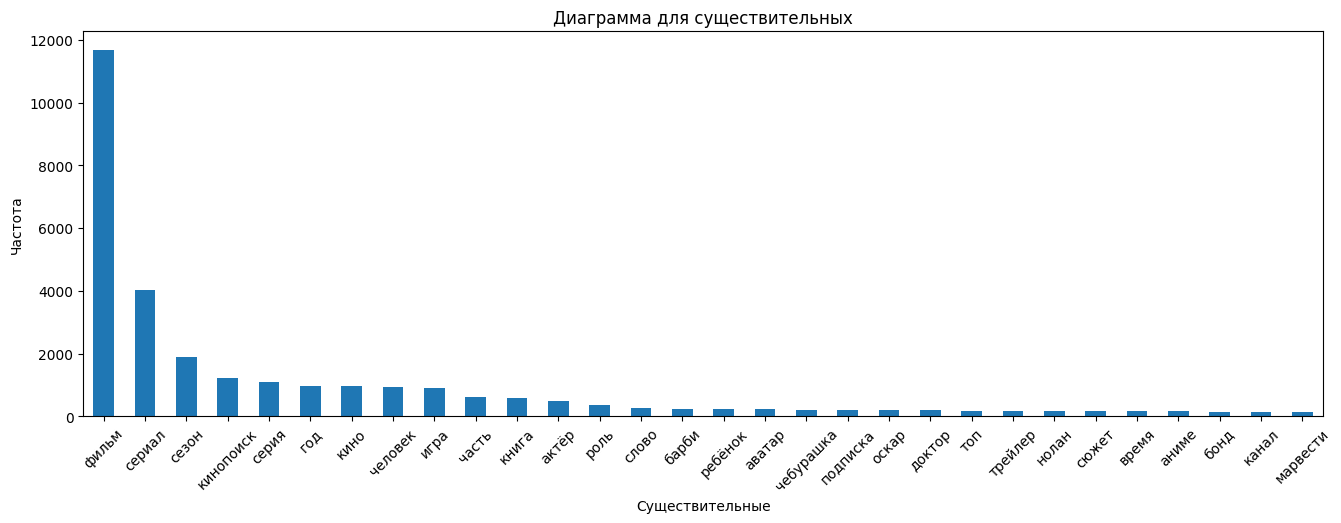

In [136]:
common_words_df.query('tags == "NOUN"')[:30].plot(kind='bar', x='word', y='qvt', rot=45, figsize=(16,5), legend=False, xlabel='Существительные', ylabel='Частота', title='Диаграмма для существительных');

Остальные части речи выведем таблицами:

In [137]:
#выводим наречия
common_words_df.query('tags == "ADVB"')[['word', 'qvt']]

word   qvt
5        очень  1272
27      вообще   278
37      почему   199
129  интересно    70

In [138]:
#выводим предикатывы
common_words_df.query('tags == "PRED"')[['word', 'qvt']]

word  qvt
101  жаль   88

In [139]:
#выводим междометия
common_words_df.query('tags == "INTJ"')[['word', 'qvt']]

word  qvt
22   спасибо  336
123      гей   73

In [140]:
#выводим частицы
common_words_df.query('tags == "PRCL"')[['word', 'qvt']]

word  qvt
13       просто  941
108  пожалуйста   83

Для наглядности, дополнительно применим форму визуализации частоты встречающихся в тексте слов в виде "облака слов":

In [141]:
# преобразуем датасет топ-200 слов обратно в словарь
word_freq = dict(zip(common_words_df['word'], common_words_df['qvt']))

# проверяем результат
list(word_freq.items())[:5]

[('фильм', 11678),
 ('сериал', 4044),
 ('смотреть', 3684),
 ('сезон', 1890),
 ('хороший', 1565)]

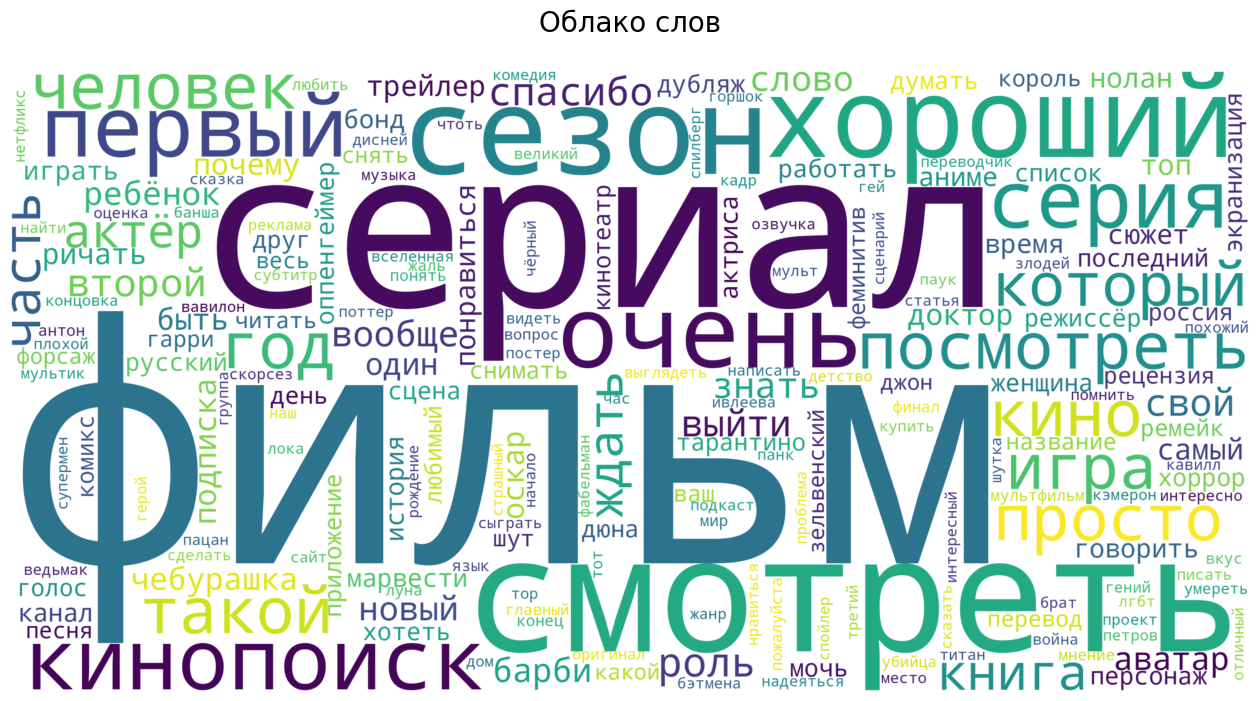

In [142]:
# Создаем объект WordCloud
wordcloud = WordCloud(width = 3000, height = 1500, random_state=1, background_color="white").generate_from_frequencies(word_freq)

# Отображаем облако слов
plt.figure(figsize=(16, 9))#, dpi=300)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Облако слов', fontsize=20, y=1.05)
plt.show()

Можно подвести некоторый итог проделанной работы. Итак, если верить полученным ключевым словам, пользователи в комментариях делятся своими переживаниями по тому поводу как смотреть/посмотреть, ждать, знать, когда выйдет очень хороший, первый, такой, который, второй, свой, новый, один, самый, последний, русский, любимый фильм, сериал, сезон, серия, кино, часть, которая поставлена по такой-то книге и в которой такую-то роль играет такой-то актёр в таком-то году и снималось столько-то человек. Кинопоиск, видимо упоминается, в контексте получения информации или контента на интересующие людей темы.\
*Можно предположить, что в выбраннном нами сегменте комментариев, вызывающему повышеннную активность пользователей основным драйвером является потребность поделится своими переживаниями по поводу ожидания выхода наиболее мейнстримных фильмов, новых сезонов сериалов, а также обмен мнениями по поводу уже вышедших предыдущих частей и/или работ актёров. Т.е. здесь активность подписчиков должны вызывать публикации в которых будет информация о наиболее ожидаемых кинопродуктах.*\
Возможно, если мы проанализируем другой сегмент, с малой активностью пользователей, то там будет получена другая картина, однако, это выходит за рамки нашего исследования.\
С помошью диаграммы рассеивания, постараемся выяснить, какое доминирующее настроение демонстрируют пользователи в своих комментариях:

In [143]:
#готовим данные к визуализации
# Разделяем значения на два столбца
df_semantics[['negative', 'positive']] = df_semantics['sentiment'].apply(pd.Series)

# Проверяем все значения в колонке c негативным компонентом имеют отрицательное значение
for value in df_semantics['negative']:
    # Если значение больше 0, меняем его на отрицательное
    if value > 0:
        df_semantics['negative'] = df_semantics['negative'].apply(lambda x: -1 * np.sign(x) * x)

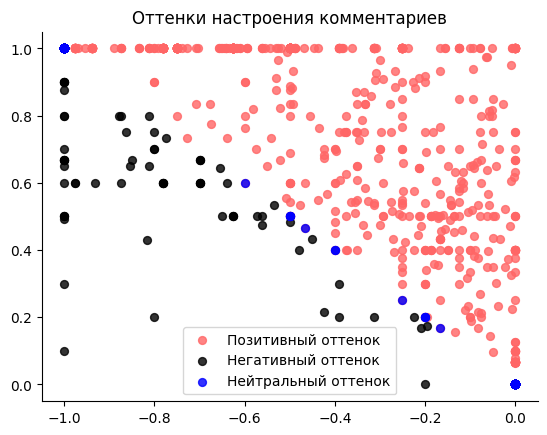

In [144]:
#делаем диаграмму рассеяния
mask = df_semantics['positive'] >= df_semantics['negative'] * -1
above_diagonal = df_semantics[mask]

mask = df_semantics['positive'] < df_semantics['negative'] * -1
below_diagonal = df_semantics[mask]

mask = df_semantics['negative'] == df_semantics['positive'] * -1
diagonal = df_semantics[mask]

plt.scatter(above_diagonal['negative'], above_diagonal['positive'],c='#ff6666', s=32, alpha=0.8, label='Позитивный оттенок')
plt.scatter(below_diagonal['negative'], below_diagonal['positive'], c= 'black', s=32, alpha=0.8, label='Негативный оттенок')
plt.scatter(diagonal['negative'], diagonal['positive'], c='blue', s=32, alpha=0.8, label='Нейтральный оттенок')

plt.gca().spines[['top', 'right']].set_visible(False)
plt.title('Оттенки настроения комментариев')
plt.legend()
plt.show()

На диаграмме рассеивания чётко видно, что большая часть оставляемых пользователями комментариев имеет всё же положительный оттенок и доля остроотрицательных заметок не так уж велика.\
*Подытоживая можно сказать, что основными драйверами количества комментариев пользователей на Кинопоиске являются, во-первых, побуждающие посты Кинопоска с призывами оставлять комментарии, и, во-вторых, публикации о наиболее ожидаемых новинках кинопродукции.*

## Краткие итоги

Нами был проведён разносторонний анализ метрик канала Кинопоиск за период с августа 2022 по конец января 2024 года.\
С помощью визуализаций мы выделили *периоды роста, стагнации и отката числа подписчиков* канала. Выделены `даты пиковых значений роста и падений` для использования их продуктологами и маркетологами в целях качественного анализа.\
Было отмечено также значительное превалирование суточных значений отписки над подпиской в сентябре и середине ноября 2023 года, что вполне согласовывалось с падением уровня просмотров.\
*Мониторинг средней подписочной динамики в течении суток* показал, что максимальный уровень отписки происходит с 4-х до 6-и часов утра, в связи с чем было сделано предположение, что заказчику следует ограничить отсылку каких-либо постов в то время по московскому часовому поясу. По дням недели наилучший результат даёт вторник, пятница и суббота, с безусловным лидированием пятницы. Наихудший - понедельник.\
*Анализ реакций подписчиков* на публикации показал, что несмотря на существенный рост подписки с середины ноября, реакции подписчиков изменялись разнонаправленно: совсем не выросло среднее за сутки количество комментариев пользователей, не показал прямо пропорционального роста и эмоциональный компонент, в то время как число пересылок наилучшим образом коррелировало с ростом числа подписчиков.\
Кроме того, было обнаружено, что публикации с разным вложением по разному влияют на число просмотров и рост подписки. Так, на этапе спада превалируют посты с вложением в виде ссылки, а на этапе подъёма - видео вложения.\
Также установлено, что *тип вложения* по разному влияет на количество комментариев. Наибольшее их число появляется под постами с изображениями.\
Исследована также *зависимость количества просмотров от характеристик объёма и сложности текстов* и сделаны соотвествующие выводы.\
Интересным выглядит факт, что *движение показателей ER и ERR* часто носит разнонаправленный характер, что может служить предметом отдельного анализа со стороны маркетологов и продуктологов.\
*В ходе анализа эмотиконов* были внедрены 3 новые метрики: PEM (положительная метрика), NEM (отрицательная метрика) и WEM (эмпато-сострадательная метрика). В ходе анализа визуализаций указанных метрик была обнаружена зависимость между падением уровня просмотров и ростов негативной метрики, на что заказчику тоже следовало бы обратить внимание.\
Никакой корреляции между тематиками постов и их иными характеристиками выявить не удалось.\
*Семантический анализ* показал, что основными драйверами увеличения количества комментариев пользователей на Кинопоиске, являются, во-первых, побуждающие посты Кинопоска с призывами оставлять комментарии, и, во-вторых, публикации о наиболее ожидаемых новинках кинопродукции.\
*В качестве KPI* предложено использовать процент роста подписчиков в "мирное время" и в условиях вирусной механики. Выделены их возможные числовые значения. Кроме того, обосновано, что KPI может являтся соблюдение каналом определённого `соотношения между постами с различным типом вложения`, `рост реакций пользователей в виде пересылок`, а также `показатель негативной эмоциональной реакции NEM`.\
Безусловно, данное исследование не является исчерпывающим и каждый затронутый аспект может быть развёрнут в более детальную отдельную работу, с выдвижением и проверкой соответвующих гипотез, а также формулированием рекомендаций и управленческих действий на этой основе.
